In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, iqr
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
import seaborn as sns
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

In [134]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

#FENS animals
#animalnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#November 2022 animals
animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_16','DS_17','DS_19','DS_22']

#Combined
#animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_16','BS_95','BS_113']

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#animals['BS_33'].reversal = 20
#animals['BS_73'].reversal = np.nan
#animals['BS_78'].reversal = np.nan
#animals['BS_52'].reversal = 15
animals['BS_108'].reversal = 7
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_51'].reversal = 8
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
animals['BS_70'].reversal = 11
animals['BS_72'].reversal = 6
animals['BS_87'].reversal = 6

#FENS
#animals['BS_113'].reversal = 13
#animals['BS_95'].reversal = 8
#animals['BS_50'].reversal = 12
#animals['BS_85'].reversal = 10
#animals['BS_83'].reversal = 20

#November 2022
animals['BS_67'].reversal = 7
animals['BS_61'].reversal = 9    ###
#animals['DS_16'].reversal = 11

BS_40
BS_41
BS_42
BS_49
BS_51
BS_56
BS_59
BS_61
BS_67
BS_70
BS_72
BS_87
BS_108


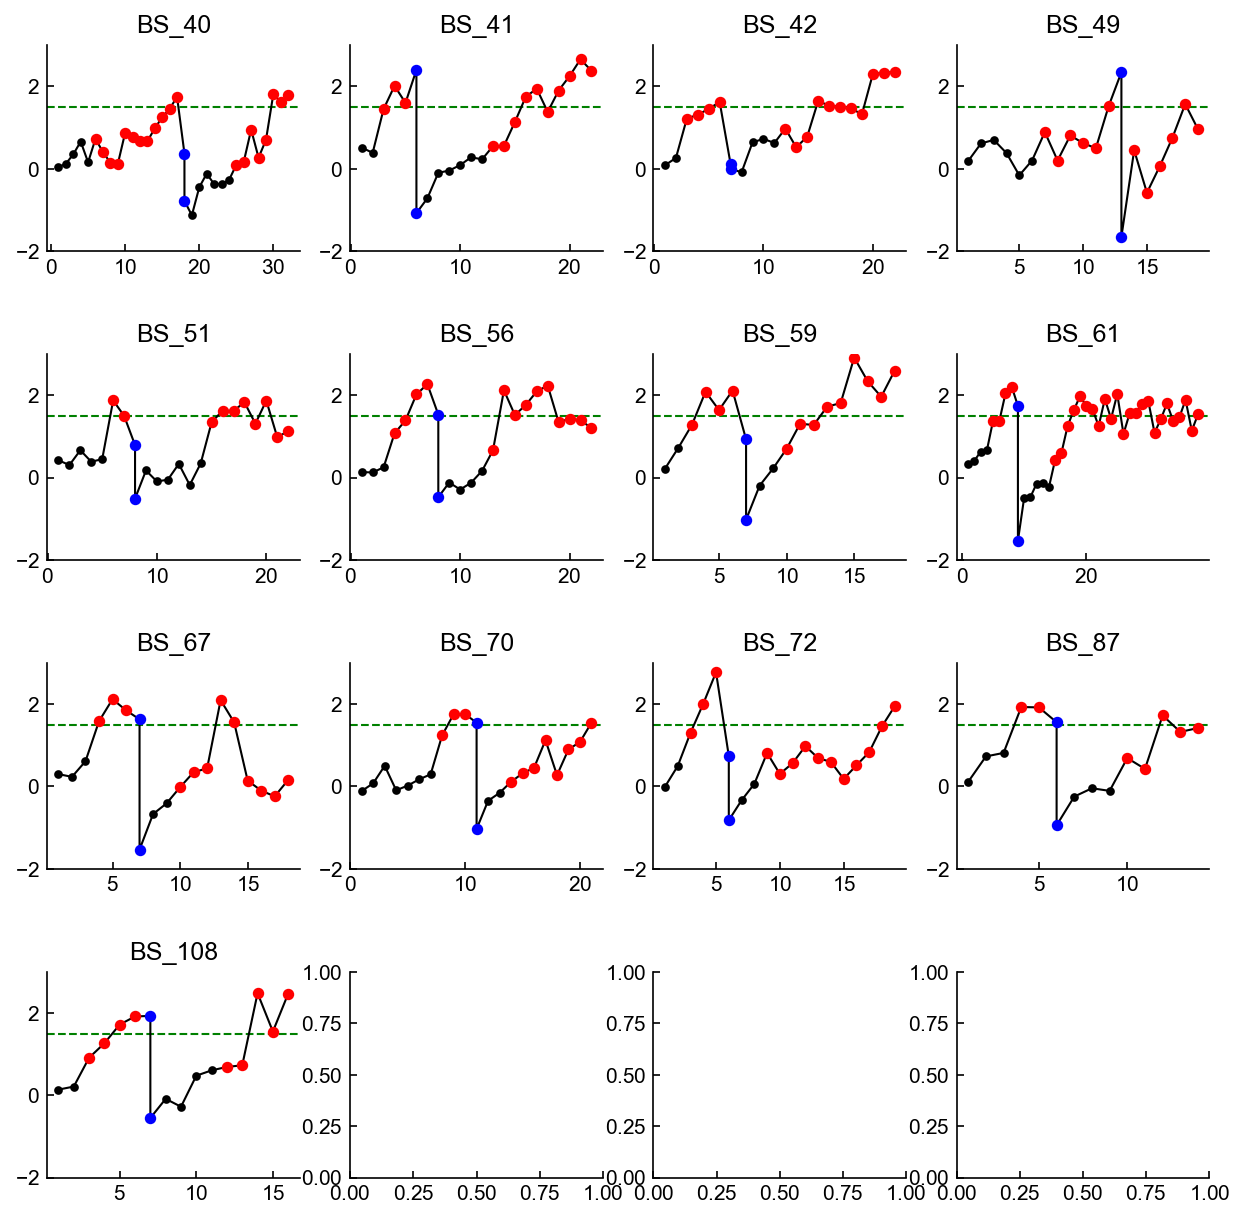

In [135]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMT.csv')
#filename = os.path.join('C:\\\\Users','4thgr','Desktop','DataForJMT.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
for animalidx,animal in enumerate(animals):
    print(animal)
    
    condname = 'd\' ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal:
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[maxreversaldp])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    maxperf = np.nanmax(postreversaldps)
    minperf = np.nanmin(np.concatenate((postreversaldps,[minreversaldp])))
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday),np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])

        ax.set_title(animal)
if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','Middle cutoff FENS+Nov22.png'),transparent=False,facecolor="white")
    pass

In [4]:
def plotUnitGivenAx(ax1,ax2,sessionfile,clust):

        starttime = -0.5
        endtime = 2.5
        numbins = 100 + 1

        height=10
        width=1
        trans=0.25
        custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)
    
        ##########################################################################################################################
        #Condition A
        conditionA = SimpleNamespace()
        conditionA.trials = sessionfile.trim[clust].trimmed_trials
        conditionA.label = 'Trimmed Trials'
        conditionA.color = 'black'

        conditions = [conditionA]
        #Convert trials into idxs -- more useful for algorithm
        #Not currently needed because trim_trials is already in that format
        for cond in conditions:
            pass
            #cond.trials = np.array(np.where(cond.trials)[0])
        ##########################################################################################################################
        totaltrials = 0
        for cond in conditions:
            totaltrials += len(cond.trials)
            
        #Caching search -- Unit
        idx = np.equal(sessionfile.spikes.clusters,clust)
        totaltimes = sessionfile.spikes.times[idx]
            
        for cond in conditions:         
            cond.latency = []
            cond.firingrates = []
            cond.timestoplot = []
            cond.trialstoplot = []
            cond.responsetimestoplot = []
            cond.responsetrialstoplot = []
            cond.peristimulustimes = []
            cond.onsetmodulation = np.nan
            cond.offsetmodulation = np.nan
            cond.pc = np.nan
            cond.dp = np.nan
                        
            ##Calculate Behavior Stats
            #temparray = np.zeros(sessionfile.meta.length_in_trials)
            #temparray[cond.trials] = np.ones(len(cond.trials))
            #condhits = np.sum(np.logical_and(temparray,Hits))
            #condmisses = np.sum(np.logical_and(temparray,Misses))
            #condfalarms = np.sum(np.logical_and(temparray,FAlarms))
            #condcrejects = np.sum(np.logical_and(temparray,CRejects))
            #    
            #try:
            #    cond.pc = (condhits+condmisses) / (condhits+condmisses+condfalarms+condcrejects)
            #except Exception:
            #    pass
            #try:
            #    cond.dp = norm.ppf((condhits+1)/(condhits+condmisses+2)) - norm.ppf((condfalarms+1)/(condfalarms+condcrejects+2))
            #except Exception:
            #    pass
                
            for trialidx in range(len(cond.trials)):
                trial = cond.trials[trialidx]
                trialstart = sessionfile.trials.starts[trial]
                    
                #Caching search -- Condition
                idx = np.logical_and(      np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs)     )
                times = totaltimes[idx]
                    
                #PSTH times
                cond.peristimulustimes = np.concatenate((cond.peristimulustimes,(times-trialstart)/sessionfile.meta.fs*1000))
                    
                #Response times
                if (sessionfile.trials.go[trial]):
                    cond.responsetimestoplot.append((sessionfile.trials.response[trial]-trialstart)/sessionfile.meta.fs*1000)
                    cond.responsetrialstoplot.append(trialidx+1)
                    
                #Each spike time to plot
                for spike in ((times-trialstart)/sessionfile.meta.fs*1000):
                    cond.timestoplot.append(spike)
                    cond.trialstoplot.append(trialidx+1)
                    
                #Caching search -- Tone Period
                binstart = trialstart+0*sessionfile.meta.fs
                binend = trialstart+0.1*sessionfile.meta.fs
                idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                timestone = totaltimes[idxtone]
                #Latency and firing rate
                if len(timestone)>0:
                    cond.latency.append( (np.min(timestone)-trialstart)/sessionfile.meta.fs*1000)
                else:
                    cond.latency.append(np.nan)
                cond.firingrates.append(len(timestone) / (0.1))
                        
                        
            #############################################---PLOTTING---#############################################
                
            #Plot Rasters
            #ylims1 = [1,totaltrials]
            offset = 0
            tickmeans = []
            ticklabels = []
            numtrials = 0
            for cond in [conditions[0]]:
                ax1.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=7.5,c=cond.color,marker=custommarker.vertices)
                #ax1.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
                tickmeans.append(0.5*len(cond.trials)+offset)
                #ax1.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
                offset += len(cond.trials)
                numtrials += len(cond.trials)
            ylims1 = [1,numtrials]
            #Label Conditions
            #ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            ax1.set_ylim(ylims1)
            #ax1.set_yticks(tickmeans,minor=False)
            #ax1.set_yticklabels(ticklabels,rotation=45)
            #Plot Tone/Laser
            ax1.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            ax1.set_ylabel('Trial')
            
            #Plot PSTHs
            bw=0.025
            xrange = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
            ind = 0
            for cond in [conditions[0]]:
                try:
                    KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrange)
                    FR = KDE * len(cond.peristimulustimes) / len(cond.trials) * 1000
                    #if(sigs[ind]):
                    ax2.plot(xrange,FR,c=cond.color,lw=2)
                    #else:
                    #    ax2.plot(xrange,targetmean*KDE/np.mean(KDE),c=cond.color,lw=2,alpha=0.25)
                except Exception as e:
                    print('PSTHs: '+str(e))
                ind = ind + 1
                
            ax2.set_xticks([0,1000,2000])
            ax2.set_xticklabels([0,1,2])

            ylims2 = ax2.get_ylim()
            ax2.fill_between([0,100],[ylims2[1],ylims2[1]],color='grey',alpha=trans)
            ax2.set_ylabel('Spikes per second')
            ax2.set_xlabel('Time (s)')
            
            ax1.set_xlim([-500,2500])

# Process and Cache Data

In [2]:
starttime = pytime.time()

#if False:
if True:    
    #Trim Sessions
    ilep.trimSessions('S:\\Sorts\DualRecording',replace=False)
    #endtime1 = pytime.time()
    #print('END TRIMMING')
    #Calculate Responsiveness
    ilep.calculateResponsiveness('S:\\Sorts\DualRecording',replace=True)
    #endtime2 = pytime.time()
    #print('END RESPONSIVENESS')
    #Finish
    ilep.loadSessionsComplete('S:\\Sorts\DualRecording',verbose=False)
    endtime3 = pytime.time()
    print('END PROCESS')
    #print('Trimming       : ' + str((endtime1-starttime)/60)+' minutes elapsed');
    #print('Responsiveness : ' + str((endtime2-starttime)/60)+' minutes elapsed');
    print('Finished       : ' + str((endtime3-starttime)/60)+' minutes elapsed');

 12%|█▏        | 3/25 [00:00<00:00, 28.83it/s]

S:\Sorts\DualRecording\BS_108\BS_108 5\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 7\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 8\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 9\AC\session_metadata.json missing. Skipping
BS_108 complete
S:\Sorts\DualRecording\BS_113\BS_113 8\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_113\BS_113 9\AC\session_metadata.json missing. Skipping
BS_113 complete
S:\Sorts\DualRecording\BS_33\BS_33 7\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 7\M2\session_metadata.json missing. Skipping
BS_33 complete
S:\Sorts\DualRecording\BS_40\BS_40 21\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 21\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 22\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 25\M2\session_metadata.

 32%|███▏      | 8/25 [00:00<00:01, 12.49it/s]

BS_42 complete
S:\Sorts\DualRecording\BS_49\BS_49 10\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 11\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 12\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 12\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 13\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 18\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 3\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 3\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 8\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 9\AC\session_metadata.json missing. Skipping
BS_49 complete
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_50\\BS_50 1\\AC\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_

 56%|█████▌    | 14/25 [00:00<00:00, 22.58it/s]

S:\Sorts\DualRecording\BS_56\BS_56 1\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 6\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 6\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 7\M2\session_metadata.json missing. Skipping
BS_56 complete
S:\Sorts\DualRecording\BS_59\BS_59 1\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 2\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 3\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 4\AC\session_metadata.json missing. Skipping
BS_59 complete
S:\Sorts\DualRecording\BS_67\BS_67 4.txt\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_67\BS_67 4.txt\M2\session_metadata.json missing. Skipping
BS_67 complete
S:\Sorts\DualRecording\BS_70\BS_70 2\AC\session_metadata.json missing. Skipping
BS_70 complete
BS_72 complete
[Errno 2] No such file or directory: 

 84%|████████▍ | 21/25 [00:00<00:00, 24.17it/s]

S:\Sorts\DualRecording\BS_85\BS_85 13\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 5\AC\session_metadata.json missing. Skipping
BS_85 complete
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_87\\BS_87 10\\M2\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_87\\BS_87 10\\M2\\responsiveness.pickle'
S:\Sorts\DualRecording\BS_87\BS_87 10\M2: 'group'
S:\Sorts\DualRecording\BS_87\BS_87 11\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_87\BS_87 3\AC\session_metadata.json missing. Skipping
BS_87 complete
S:\Sorts\DualRecording\BS_95\BS_95 5\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 5\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 6\AC\session_metadata.json missing. Skipping
BS_95 complete
S:\Sorts\DualRecording\DS_15\DS_15 1\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 14\M2\session_metadata

  9%|▉         | 37/398 [00:00<00:00, 366.25it/s]

[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\M2\\responsiveness.pickle'
S:\Sorts\DualRecording\DS_16\DS_16 9\M2: 'types.SimpleNamespace' object has no attribute 'length_in_samples'
DS_16 complete
S:\Sorts\DualRecording\DS_17\DS_17 29\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_17\DS_17 30\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_17\DS_17 31\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_17\DS_17 31\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_17\DS_17 32\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_17\DS_17 33\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_17\DS_17 34\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_17\DS_17 35\M2\session_metadata.json missing. Skipping
DS_17 complete
S:\Sorts\DualRecording\DS_19\DS_19 1\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_

  0%|          | 0/25 [00:00<?, ?it/s]

S:\Sorts\DualRecording\BS_108\BS_108 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 2\AC\session_metadata.json complete


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


S:\Sorts\DualRecording\BS_108\BS_108 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 3\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 3\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 4\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 4\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 5\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 5\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 6\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 6\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 7\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 7\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 8\AC\session_metadata.json missing. Skipping


  4%|▍         | 1/25 [02:17<54:58, 137.42s/it]

S:\Sorts\DualRecording\BS_108\BS_108 8\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_108\BS_108 9\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 9\M2\session_metadata.json complete
BS_108 complete
S:\Sorts\DualRecording\BS_113\BS_113 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_113\BS_113 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_113\BS_113 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_113\BS_113 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_113\BS_113 3\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_113\BS_113 3\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_113\BS_113 4\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_113\BS_113 4\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_113\BS_113 5\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_113\BS_113 5\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_

  8%|▊         | 2/25 [05:13<1:01:18, 159.93s/it]

S:\Sorts\DualRecording\BS_113\BS_113 9\M2\session_metadata.json complete
BS_113 complete
S:\Sorts\DualRecording\BS_33\BS_33 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 10\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 10\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 11\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 11\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 12\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 12\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 13\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 13\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 15\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 15\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_33\BS_33 16\AC\session_

 12%|█▏        | 3/25 [10:56<1:29:17, 243.54s/it]

S:\Sorts\DualRecording\BS_33\BS_33 9\M2\session_metadata.json complete
BS_33 complete
S:\Sorts\DualRecording\BS_40\BS_40 10\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 10\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 11\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 11\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 12\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 12\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 13\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 13\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 14\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 14\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 19\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 19\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 2\AC\session_me

 16%|█▌        | 4/25 [16:49<1:40:27, 287.00s/it]

S:\Sorts\DualRecording\BS_40\BS_40 8\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_40\BS_40 8\M2\session_metadata.json missing. Skipping
BS_40 complete
S:\Sorts\DualRecording\BS_41\BS_41 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 10\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 10\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 11\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 11\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 12\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 12\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 13\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_41\BS_41 13\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 2

 20%|██        | 5/25 [21:04<1:31:48, 275.42s/it]

S:\Sorts\DualRecording\BS_41\BS_41 9\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_41\BS_41 9\M2\session_metadata.json missing. Skipping
BS_41 complete
S:\Sorts\DualRecording\BS_42\BS_42 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 10\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 10\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 11\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 11\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 12\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 12\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 3\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_42\BS_42 3\M2\session

 24%|██▍       | 6/25 [26:28<1:32:24, 291.80s/it]

S:\Sorts\DualRecording\BS_42\BS_42 9\M2\session_metadata.json complete
BS_42 complete
S:\Sorts\DualRecording\BS_49\BS_49 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_49\BS_49 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_49\BS_49 10\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_49\BS_49 10\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 11\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_49\BS_49 11\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 12\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 12\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 13\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_49\BS_49 13\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 14\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_49\BS_49 14\M2\session_metadata.json complete
S:\Sort

 28%|██▊       | 7/25 [28:21<1:10:00, 233.35s/it]

S:\Sorts\DualRecording\BS_49\BS_49 9\M2\session_metadata.json complete
BS_49 complete
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_50\\BS_50 1\\AC\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_50\\BS_50 1\\AC\\responsiveness.pickle'
S:\Sorts\DualRecording\BS_50\BS_50 1\AC: 'group'
S:\Sorts\DualRecording\BS_50\BS_50 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_50\BS_50 10\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_50\BS_50 10\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_50\BS_50 11\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_50\BS_50 11\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_50\BS_50 12\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_50\BS_50 12\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_50\BS_50 13\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_50\BS_50 13\M2\session_metadata.json missi

 32%|███▏      | 8/25 [29:40<52:15, 184.44s/it]  

S:\Sorts\DualRecording\BS_50\BS_50 9\M2\session_metadata.json complete
BS_50 complete
S:\Sorts\DualRecording\BS_51\BS_51 1\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_51\BS_51 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_51\BS_51 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_51\BS_51 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_51\BS_51 3\AC\session_metadata.json complete


 36%|███▌      | 9/25 [30:00<35:27, 132.98s/it]

S:\Sorts\DualRecording\BS_51\BS_51 3\M2\session_metadata.json complete
BS_51 complete
S:\Sorts\DualRecording\BS_56\BS_56 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_56\BS_56 1\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_56\BS_56 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_56\BS_56 3\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_56\BS_56 3\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_56\BS_56 4\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_56\BS_56 4\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_56\BS_56 6\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 6\M2\session_metadata.json missing. Skipping


 40%|████      | 10/25 [31:06<28:03, 112.26s/it]

S:\Sorts\DualRecording\BS_56\BS_56 7\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_56\BS_56 7\M2\session_metadata.json missing. Skipping
BS_56 complete
S:\Sorts\DualRecording\BS_59\BS_59 1\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_59\BS_59 2\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_59\BS_59 3\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 3\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_59\BS_59 4\AC\session_metadata.json missing. Skipping


 44%|████▍     | 11/25 [31:48<21:08, 90.64s/it] 

S:\Sorts\DualRecording\BS_59\BS_59 4\M2\session_metadata.json complete
BS_59 complete
S:\Sorts\DualRecording\BS_67\BS_67 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_67\BS_67 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_67\BS_67 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_67\BS_67 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_67\BS_67 3\AC\session_metadata.json complete


 48%|████▊     | 12/25 [32:06<14:53, 68.74s/it]

S:\Sorts\DualRecording\BS_67\BS_67 3\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_67\BS_67 4.txt\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_67\BS_67 4.txt\M2\session_metadata.json missing. Skipping
BS_67 complete
S:\Sorts\DualRecording\BS_70\BS_70 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_70\BS_70 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_70\BS_70 10\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_70\BS_70 10\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_70\BS_70 11\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_70\BS_70 11\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_70\BS_70 12\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_70\BS_70 12\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_70\BS_70 13\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_70\BS_70 13\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_70

 52%|█████▏    | 13/25 [35:30<21:55, 109.65s/it]

S:\Sorts\DualRecording\BS_70\BS_70 9\M2\session_metadata.json complete
BS_70 complete
S:\Sorts\DualRecording\BS_72\BS_72 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 10\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 10\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 11\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 11\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 12\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 12\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 14\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 14\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_72\BS_72 3\AC\session_metada

 56%|█████▌    | 14/25 [38:42<24:40, 134.56s/it]

S:\Sorts\DualRecording\BS_72\BS_72 9\M2\session_metadata.json complete
BS_72 complete
S:\Sorts\DualRecording\BS_73\BS_73 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_73\BS_73 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_73\BS_73 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_73\BS_73 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_73\BS_73 3\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_73\BS_73 3\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_73\BS_73 4\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_73\BS_73 4\M2\session_metadata.json complete
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_73\\BS_73 5\\AC\\analog_metadata.json'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_73\\BS_73 5\\AC\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_73\\BS_73 5\\AC\\responsiveness.pickle'
S:\Sorts\DualRecording\BS_73\BS_73 5

 60%|██████    | 15/25 [40:04<19:45, 118.54s/it]

S:\Sorts\DualRecording\BS_73\BS_73 8\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_73\BS_73 8\M2\session_metadata.json complete
BS_73 complete
S:\Sorts\DualRecording\BS_78\BS_78 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_78\BS_78 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_78\BS_78 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_78\BS_78 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_78\BS_78 3\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_78\BS_78 3\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_78\BS_78 4\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_78\BS_78 4\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_78\BS_78 5\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_78\BS_78 5\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_78\BS_78 6\AC\session_metadata.json complete


 64%|██████▍   | 16/25 [40:34<13:48, 92.08s/it] 

S:\Sorts\DualRecording\BS_78\BS_78 6\M2\session_metadata.json complete
BS_78 complete
S:\Sorts\DualRecording\BS_83\BS_83 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 10\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 10\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 3\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 3\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 4\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 4\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 5\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 5\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_83\BS_83 6\AC\session_metadata.jso

 68%|██████▊   | 17/25 [43:43<16:10, 121.25s/it]

S:\Sorts\DualRecording\BS_83\BS_83 9\M2\session_metadata.json complete
BS_83 complete
S:\Sorts\DualRecording\BS_85\BS_85 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 10\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 10\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 11\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 11\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 12\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 12\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 13\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 13\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 14\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 14\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_85\BS_85 2\AC\ses

 72%|███████▏  | 18/25 [47:32<17:53, 153.40s/it]

S:\Sorts\DualRecording\BS_85\BS_85 9\M2\session_metadata.json complete
BS_85 complete
S:\Sorts\DualRecording\BS_87\BS_87 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_87\BS_87 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_87\BS_87 10\AC\session_metadata.json complete
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_87\\BS_87 10\\M2\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_87\\BS_87 10\\M2\\responsiveness.pickle'
S:\Sorts\DualRecording\BS_87\BS_87 10\M2: 'group'
S:\Sorts\DualRecording\BS_87\BS_87 11\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_87\BS_87 11\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_87\BS_87 12\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_87\BS_87 12\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_87\BS_87 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_87\BS_87 2\M2\session_metadata.json complete
S:\So

 76%|███████▌  | 19/25 [50:39<16:21, 163.59s/it]

S:\Sorts\DualRecording\BS_87\BS_87 9\M2\session_metadata.json complete
BS_87 complete
S:\Sorts\DualRecording\BS_95\BS_95 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_95\BS_95 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_95\BS_95 2\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_95\BS_95 2\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_95\BS_95 3\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_95\BS_95 3\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_95\BS_95 4\AC\session_metadata.json complete
S:\Sorts\DualRecording\BS_95\BS_95 4\M2\session_metadata.json complete
S:\Sorts\DualRecording\BS_95\BS_95 5\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 5\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 6\AC\session_metadata.json missing. Skipping


 80%|████████  | 20/25 [52:25<12:11, 146.25s/it]

S:\Sorts\DualRecording\BS_95\BS_95 6\M2\session_metadata.json complete
BS_95 complete
S:\Sorts\DualRecording\DS_15\DS_15 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_15\DS_15 1\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 14\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_15\DS_15 14\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 15\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_15\DS_15 15\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 16\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_15\DS_15 16\M2\session_metadata.json missing. Skipping


 84%|████████▍ | 21/25 [54:03<08:47, 131.81s/it]

S:\Sorts\DualRecording\DS_15\DS_15 17\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_15\DS_15 17\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 18\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 18\M2\session_metadata.json missing. Skipping
DS_15 complete
S:\Sorts\DualRecording\DS_16\DS_16 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_16\DS_16 1\M2\session_metadata.json complete
S:\Sorts\DualRecording\DS_16\DS_16 10\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_16\DS_16 10\M2\session_metadata.json complete
S:\Sorts\DualRecording\DS_16\DS_16 11\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_16\DS_16 11\M2\session_metadata.json complete
S:\Sorts\DualRecording\DS_16\DS_16 12\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_16\DS_16 12\M2\session_metadata.json complete
S:\Sorts\DualRecording\DS_16\DS_16 13\AC\session_metadata.json complete
S:\Sorts\DualRecording\D

 88%|████████▊ | 22/25 [1:02:17<12:01, 240.57s/it]

S:\Sorts\DualRecording\DS_16\DS_16 8\M2\session_metadata.json complete
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\AC\\analog_metadata.json'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\AC\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\AC\\responsiveness.pickle'
S:\Sorts\DualRecording\DS_16\DS_16 9\AC: 'types.SimpleNamespace' object has no attribute 'length_in_samples'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\M2\\analog_metadata.json'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\M2\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\M2\\responsiveness.pickle'
S:\Sorts\DualRecording\DS_16\DS_16 9\M2: 'types.SimpleNamespace' object has no attribute 'length_in_samples'
DS_16 complete
S:\Sorts\DualRecording\DS_17\DS_17 29\AC\session_metadata.json complete
S:\S

 92%|█████████▏| 23/25 [1:03:16<06:11, 185.96s/it]

S:\Sorts\DualRecording\DS_17\DS_17 35\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_17\DS_17 35\M2\session_metadata.json missing. Skipping
DS_17 complete
S:\Sorts\DualRecording\DS_19\DS_19 1\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_19\DS_19 1\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 28\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_19\DS_19 28\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 29\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_19\DS_19 29\M2\session_metadata.json missing. Skipping


 96%|█████████▌| 24/25 [1:03:35<02:15, 135.79s/it]

S:\Sorts\DualRecording\DS_19\DS_19 30\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_19\DS_19 30\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 32\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 32\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 33\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 33\M2\session_metadata.json missing. Skipping
DS_19 complete
S:\Sorts\DualRecording\DS_22\DS_22 15\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_22\DS_22 15\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_22\DS_22 16\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_22\DS_22 16\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_22\DS_22 17\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_22\DS_22 17\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_22\DS_22 18\AC\session_

  0%|          | 0/25 [00:00<?, ?it/s]

S:\Sorts\DualRecording\DS_22\DS_22 21\AC\session_metadata.json complete
S:\Sorts\DualRecording\DS_22\DS_22 21\M2\session_metadata.json missing. Skipping
DS_22 complete
S:\Sorts\DualRecording complete
S:\Sorts\DualRecording\BS_108\BS_108 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 4\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 5\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 5\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 6\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 7\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 7\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 8\AC\session_metad

  4%|▍         | 1/25 [00:08<03:33,  8.90s/it]

S:\Sorts\DualRecording\BS_108\BS_108 9\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_108\BS_108 9\MGB\session_metadata.json missing. Skipping
BS_108 complete
S:\Sorts\DualRecording\BS_113\BS_113 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_113\BS_113 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_113\BS_113 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_113\BS_113 4\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_113\BS_113 5\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_113\BS_113 6\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_113\BS_113 7\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_113\BS_113 8\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_113\BS_113 8\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_113\BS_113 9\AC\session_metadata.json missing. 

  8%|▊         | 2/25 [00:19<03:53, 10.13s/it]

S:\Sorts\DualRecording\BS_113\BS_113 9\MGB\session_metadata.json missing. Skipping
BS_113 complete
S:\Sorts\DualRecording\BS_33\BS_33 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 13\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 15\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 16\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 17\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_33\BS_33 4\MGB\session_metadata.json missing. Skipping
S:\

 12%|█▏        | 3/25 [00:41<05:40, 15.46s/it]

S:\Sorts\DualRecording\BS_33\BS_33 9\MGB\session_metadata.json missing. Skipping
BS_33 complete
S:\Sorts\DualRecording\BS_40\BS_40 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 13\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 14\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 19\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 20\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 21\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 21\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 21\MGB\session_metadata.json missing. Skipping
S:\So

 16%|█▌        | 4/25 [01:03<06:19, 18.05s/it]

S:\Sorts\DualRecording\BS_40\BS_40 8\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_40\BS_40 8\MGB\session_metadata.json missing. Skipping
BS_40 complete
S:\Sorts\DualRecording\BS_41\BS_41 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_41\BS_41 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_41\BS_41 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_41\BS_41 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_41\BS_41 13\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_41\BS_41 13\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_41\BS_41 2\MGB\session_metadata.json missing. Skipping
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_41\\BS_41 3\\AC\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_41\\BS_41 3\\AC\\responsiveness.pickle'
S:\Sorts\DualRecording\BS_41\BS_41 3\AC: 'group'


 20%|██        | 5/25 [01:20<05:53, 17.68s/it]

S:\Sorts\DualRecording\BS_41\BS_41 9\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_41\BS_41 9\MGB\session_metadata.json missing. Skipping
BS_41 complete
S:\Sorts\DualRecording\BS_42\BS_42 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_42\BS_42 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_42\BS_42 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_42\BS_42 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_42\BS_42 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_42\BS_42 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_42\BS_42 4\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_42\BS_42 5\MGB\session_metadata.json missing. Skipping
Depth mismatch on cluster 24
Depth mismatch on cluster 26
Depth mismatch on cluster 27
Depth mismatch on cluster 39
S:\Sorts\DualRecording\BS_42\BS_42 6\MGB\session_metadata

 24%|██▍       | 6/25 [01:37<05:31, 17.44s/it]

S:\Sorts\DualRecording\BS_42\BS_42 9\MGB\session_metadata.json missing. Skipping
BS_42 complete
S:\Sorts\DualRecording\BS_49\BS_49 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 10\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 11\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 12\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 12\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 13\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 13\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_49\BS_49 14\MGB\session_metadata.json missing. Skipping
S:\Sorts

 28%|██▊       | 7/25 [01:46<04:22, 14.56s/it]

S:\Sorts\DualRecording\BS_49\BS_49 9\MGB\session_metadata.json missing. Skipping
BS_49 complete
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_50\\BS_50 1\\AC\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_50\\BS_50 1\\AC\\responsiveness.pickle'
S:\Sorts\DualRecording\BS_50\BS_50 1\AC: 'group'
S:\Sorts\DualRecording\BS_50\BS_50 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_50\BS_50 10\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_50\BS_50 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_50\BS_50 11\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_50\BS_50 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_50\BS_50 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_50\BS_50 13\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_50\BS_50 13\MGB\session_metadata.json missing. Skipping

 32%|███▏      | 8/25 [01:54<03:30, 12.41s/it]

S:\Sorts\DualRecording\BS_50\BS_50 9\MGB\session_metadata.json missing. Skipping
BS_50 complete
S:\Sorts\DualRecording\BS_51\BS_51 1\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_51\BS_51 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_51\BS_51 2\MGB\session_metadata.json missing. Skipping


 36%|███▌      | 9/25 [01:56<02:26,  9.18s/it]

S:\Sorts\DualRecording\BS_51\BS_51 3\MGB\session_metadata.json missing. Skipping
BS_51 complete
S:\Sorts\DualRecording\BS_56\BS_56 1\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 4\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 6\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 6\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 6\MGB\session_metadata.json missing. Skipping


 40%|████      | 10/25 [02:00<01:54,  7.61s/it]

S:\Sorts\DualRecording\BS_56\BS_56 7\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_56\BS_56 7\MGB\session_metadata.json missing. Skipping
BS_56 complete
S:\Sorts\DualRecording\BS_59\BS_59 1\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 2\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 3\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_59\BS_59 4\AC\session_metadata.json missing. Skipping


 44%|████▍     | 11/25 [02:03<01:26,  6.16s/it]

S:\Sorts\DualRecording\BS_59\BS_59 4\MGB\session_metadata.json missing. Skipping
BS_59 complete
S:\Sorts\DualRecording\BS_67\BS_67 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_67\BS_67 2\MGB\session_metadata.json missing. Skipping


 48%|████▊     | 12/25 [02:05<01:04,  4.96s/it]

S:\Sorts\DualRecording\BS_67\BS_67 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_67\BS_67 4.txt\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_67\BS_67 4.txt\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_67\BS_67 4.txt\MGB\session_metadata.json missing. Skipping
BS_67 complete
S:\Sorts\DualRecording\BS_70\BS_70 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_70\BS_70 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_70\BS_70 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_70\BS_70 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_70\BS_70 13\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_70\BS_70 2\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_70\BS_70 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_70\BS_70 3\MGB\session_metadata.json missing. Skipping


 52%|█████▏    | 13/25 [02:20<01:35,  7.92s/it]

S:\Sorts\DualRecording\BS_70\BS_70 9\MGB\session_metadata.json missing. Skipping
BS_70 complete
S:\Sorts\DualRecording\BS_72\BS_72 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_72\BS_72 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_72\BS_72 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_72\BS_72 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_72\BS_72 14\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_72\BS_72 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_72\BS_72 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_72\BS_72 4\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_72\BS_72 5\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_72\BS_72 6\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_72\BS_72 7\MGB\session_metadata.json missing. Skipping
S:\Sorts\

 56%|█████▌    | 14/25 [02:33<01:43,  9.45s/it]

S:\Sorts\DualRecording\BS_72\BS_72 9\MGB\session_metadata.json missing. Skipping
BS_72 complete
S:\Sorts\DualRecording\BS_73\BS_73 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_73\BS_73 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_73\BS_73 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_73\BS_73 4\MGB\session_metadata.json missing. Skipping
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_73\\BS_73 5\\AC\\analog_metadata.json'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_73\\BS_73 5\\AC\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_73\\BS_73 5\\AC\\responsiveness.pickle'
S:\Sorts\DualRecording\BS_73\BS_73 5\AC: 'types.SimpleNamespace' object has no attribute 'length_in_samples'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_73\\BS_73 5\\M2\\analog_metadata.json'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRe

 60%|██████    | 15/25 [02:40<01:29,  8.97s/it]

S:\Sorts\DualRecording\BS_73\BS_73 8\MGB\session_metadata.json missing. Skipping
BS_73 complete
S:\Sorts\DualRecording\BS_78\BS_78 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_78\BS_78 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_78\BS_78 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_78\BS_78 4\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_78\BS_78 4\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_78\BS_78 4\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_78\BS_78 5\MGB\session_metadata.json missing. Skipping


 64%|██████▍   | 16/25 [02:44<01:06,  7.44s/it]

S:\Sorts\DualRecording\BS_78\BS_78 6\MGB\session_metadata.json missing. Skipping
BS_78 complete
S:\Sorts\DualRecording\BS_83\BS_83 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_83\BS_83 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_83\BS_83 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_83\BS_83 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_83\BS_83 4\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_83\BS_83 5\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_83\BS_83 6\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_83\BS_83 7\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_83\BS_83 8\MGB\session_metadata.json missing. Skipping


 68%|██████▊   | 17/25 [02:57<01:11,  8.96s/it]

S:\Sorts\DualRecording\BS_83\BS_83 9\MGB\session_metadata.json missing. Skipping
BS_83 complete
S:\Sorts\DualRecording\BS_85\BS_85 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 13\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 13\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 14\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 4\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_85\BS_85 5\AC\session_metadata.json missing. Skipping
S:\Sorts\

 72%|███████▏  | 18/25 [03:13<01:18, 11.24s/it]

S:\Sorts\DualRecording\BS_85\BS_85 9\MGB\session_metadata.json missing. Skipping
BS_85 complete
S:\Sorts\DualRecording\BS_87\BS_87 1\MGB\session_metadata.json missing. Skipping
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_87\\BS_87 10\\M2\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\BS_87\\BS_87 10\\M2\\responsiveness.pickle'
S:\Sorts\DualRecording\BS_87\BS_87 10\M2: 'group'
S:\Sorts\DualRecording\BS_87\BS_87 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_87\BS_87 11\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_87\BS_87 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_87\BS_87 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_87\BS_87 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_87\BS_87 3\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_87\BS_87 3\MGB\session_metadata.json missing. Skippin

 76%|███████▌  | 19/25 [03:27<01:12, 12.03s/it]

S:\Sorts\DualRecording\BS_87\BS_87 9\MGB\session_metadata.json missing. Skipping
BS_87 complete
S:\Sorts\DualRecording\BS_95\BS_95 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 2\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 3\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 4\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 5\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 5\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 5\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\BS_95\BS_95 6\AC\session_metadata.json missing. Skipping


 80%|████████  | 20/25 [03:34<00:52, 10.43s/it]

S:\Sorts\DualRecording\BS_95\BS_95 6\MGB\session_metadata.json missing. Skipping
BS_95 complete
S:\Sorts\DualRecording\DS_15\DS_15 1\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 14\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 14\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 15\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 15\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 16\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 16\MGB\session_metadata.json missing. Skipping


 84%|████████▍ | 21/25 [03:39<00:35,  8.82s/it]

S:\Sorts\DualRecording\DS_15\DS_15 17\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 17\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 18\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 18\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_15\DS_15 18\MGB\session_metadata.json missing. Skipping
DS_15 complete
S:\Sorts\DualRecording\DS_16\DS_16 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_16\DS_16 10\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_16\DS_16 11\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_16\DS_16 12\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_16\DS_16 13\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_16\DS_16 13\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_16\DS_16 14\AC\session_metadata.json missing. Skipping
S:\Sort

 88%|████████▊ | 22/25 [04:09<00:45, 15.01s/it]

S:\Sorts\DualRecording\DS_16\DS_16 8\MGB\session_metadata.json missing. Skipping
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\AC\\analog_metadata.json'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\AC\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\AC\\responsiveness.pickle'
S:\Sorts\DualRecording\DS_16\DS_16 9\AC: 'types.SimpleNamespace' object has no attribute 'length_in_samples'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\M2\\analog_metadata.json'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\M2\\trim.pickle'
[Errno 2] No such file or directory: 'S:\\Sorts\\DualRecording\\DS_16\\DS_16 9\\M2\\responsiveness.pickle'
S:\Sorts\DualRecording\DS_16\DS_16 9\M2: 'types.SimpleNamespace' object has no attribute 'length_in_samples'
S:\Sorts\DualRecording\DS_16\DS_16 9\MGB\session_metadata.json missing. Skipping


 92%|█████████▏| 23/25 [04:13<00:23, 11.98s/it]

S:\Sorts\DualRecording\DS_17\DS_17 35\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_17\DS_17 35\MGB\session_metadata.json missing. Skipping
DS_17 complete
S:\Sorts\DualRecording\DS_19\DS_19 1\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 1\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 28\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 28\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 29\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 29\MGB\session_metadata.json missing. Skipping


 96%|█████████▌| 24/25 [04:16<00:09,  9.05s/it]

S:\Sorts\DualRecording\DS_19\DS_19 30\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 30\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 32\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 32\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 32\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 33\AC\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 33\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_19\DS_19 33\MGB\session_metadata.json missing. Skipping
DS_19 complete
S:\Sorts\DualRecording\DS_22\DS_22 15\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_22\DS_22 15\MGB\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_22\DS_22 16\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_22\DS_22 16\MGB\session_metadata.json missing. Skipping
S:\Sorts

100%|██████████| 25/25 [04:23<00:00, 10.52s/it]

S:\Sorts\DualRecording\DS_22\DS_22 21\M2\session_metadata.json missing. Skipping
S:\Sorts\DualRecording\DS_22\DS_22 21\MGB\session_metadata.json missing. Skipping
DS_22 complete
S:\Sorts\DualRecording complete
END PROCESS
Finished       : 69.99800419807434 minutes elapsed


# Load Cached Data

In [92]:
directory = 'D:\\Analysis_Cache'

numbersessions = 0
numberdisqlen = 0
numberdisqISI = 0
numberdisqFR = 0
numAC = 0
numM2 = 0
numTrim = 0

sessions = os.listdir(directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(directory,session)
    numbersessions += 1
    numberdisqlen += len(sessionfile.disqualified.NumTrials)
    numberdisqISI += len(sessionfile.disqualified.ISI)
    numberdisqFR += len(sessionfile.disqualified.FRthresh)

    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
    else:
        pass
    
    if hasattr(sessionfile,'trim'):
        numTrim += 1

print(str(numbersessions)+' sessions')
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))
print('Trim     : ' + str(numTrim))
print('Disq Len : ' + str(numberdisqlen))
print('Disq ISI : ' + str(numberdisqISI))
print('Disq FR  : ' + str(numberdisqFR))
print(sessionfile.meta)

398 sessions
AC       : 2797
M2       : 3004
Trim     : 398
Disq Len : 554
Disq ISI : 42
Disq FR  : 76
namespace(animal='DS_22', arraystart=0, behavior='expert', condition='postreversal expert', date='6/9/2021', day_of_recording=21, day_of_reversal=20, day_of_training=33, depth=1300, directory='D:\\DualRecording\\DS_22\\DS_22 21\\AC\\', files=['Jun 9 2021 Dual DS_22_21001'], fs=30000, length_in_minutes=25.562753333333333, length_in_samples=46012956.0, length_in_seconds=1533.7652, length_in_trials=300, lickdelayrelativetostart=0.2, lickdelayrelativetotone=0.1, probe=6928, region='AC', task='reversal', tonelength=0.1, triallength=2.5)


# Responsiveness Summaries

In [101]:
reg = 'AC'

In [136]:
preEarly = []
preMid = []
preLate = []
postEarly = []
postMid = []
postLate = []
switch = []

preEarlyClust = []
preMidClust = []
preLateClust = []
postEarlyClust = []
postMidClust = []
postLateClust = []
switchClust = []

preEarlySess = []
preMidSess = []
preLateSess = []
postEarlySess = []
postMidSess = []
postLateSess = []
switchSess = []

switchPre = []
switchPost = []

for session in sessions:
    sessionfile = ilep.loadSessionCached(directory,session)
    
    if not sessionfile.meta.region == reg:
        continue
    
    #FENS animals
    #animalstouse = ['BS_108','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87']#,'BS_95','BS_113']
    #November 2022 animals
    animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
    #Combined
    #animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_16','DS_17','DS_19','DS_22','BS_95','BS_113']
    
    if sessionfile.meta.animal not in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
    
    if sessionfile.meta.task == 'switch':
        for clust in sessionfile.clusters.good:
            switchPre.append( sessionfile.responsiveness[clust]['pre-switch'].FRmodulation )
            switchPost.append( sessionfile.responsiveness[clust]['post-switch'].FRmodulation )
    
    clusters_to_append = []
    ids_to_append = []
    sessions_to_append = []
    for clust in sessionfile.clusters.good:
        clusters_to_append.append( sessionfile.responsiveness[clust]['all_trials'].FRmodulation )
        ids_to_append.append( clust )
        sessions_to_append.append( session )
    
    if sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
        preEarly = np.concatenate((preEarly,clusters_to_append))
        preEarlyClust = np.concatenate((preEarlyClust,ids_to_append))
        preEarlySess = np.concatenate((preEarlySess,sessions_to_append))
    elif sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
        preMid = np.concatenate((preMid,clusters_to_append))
        preMidClust = np.concatenate((preMidClust,ids_to_append))
        preMidSess = np.concatenate((preMidSess,sessions_to_append))
    elif sessionfile.meta.condition == 'prereversal expert':
        preLate = np.concatenate((preLate,clusters_to_append))
        preLateClust = np.concatenate((preLateClust,ids_to_append))
        preLateSess = np.concatenate((preLateSess,sessions_to_append))
    elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
        postEarly = np.concatenate((postEarly,clusters_to_append))
        postEarlyClust = np.concatenate((postEarlyClust,ids_to_append))
        postEarlySess = np.concatenate((postEarlySess,sessions_to_append))
    elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
        postMid = np.concatenate((postMid,clusters_to_append))
        postMidClust = np.concatenate((postMidClust,ids_to_append))
        postMidSess = np.concatenate((postMidSess,sessions_to_append))
    elif sessionfile.meta.condition == 'postreversal expert':
        postLate = np.concatenate((postLate,clusters_to_append))
        postLateClust = np.concatenate((postLateClust,ids_to_append))
        postLateSess = np.concatenate((postLateSess,sessions_to_append))
    elif sessionfile.meta.condition == 'reversal':
        switch = np.concatenate((switch,clusters_to_append))
        switchClust = np.concatenate((switchClust,ids_to_append))
        switchSess = np.concatenate((switch,sessions_to_append))
        
switchPre = np.array(switchPre)
switchPost = np.array(switchPost)
            
print(reg+' Pre Early: '+str(len(preEarly))+' cells')
print(reg+' Pre Mid: '+str(len(preMid))+' cells')
print(reg+' Pre Late: '+str(len(preLate))+' cells')
print(reg+' Post Early: '+str(len(postEarly))+' cells')
print(reg+' Post Mid: '+str(len(postMid))+' cells')
print(reg+' Post Late: '+str(len(postLate))+' cells')
print(reg+' Switch: '+str(len(switch))+' cells')

AC Pre Early: 115 cells
AC Pre Mid: 174 cells
AC Pre Late: 125 cells
AC Post Early: 410 cells
AC Post Mid: 198 cells
AC Post Late: 255 cells
AC Switch: 124 cells


Significances (Bonferroni corrected)
     Early Prereversal - Middle Prereversal : 0.02125083313959523
     Early Prereversal - Late Prereversal : 0.004770316366388841
     Early Prereversal - Early Postreversal : 0.2184671485223043
     Early Prereversal - Middle Postreversal : 0.025358460965629
     Early Prereversal - Late Postreversal : 0.004317912843739247
     Middle Prereversal - Early Prereversal : 0.02125083313959523
**** Middle Prereversal - Late Prereversal : 3.298594250653608e-08
     Middle Prereversal - Early Postreversal : 0.029631297829943833
     Middle Prereversal - Middle Postreversal : 0.37322499103137274
**** Middle Prereversal - Late Postreversal : 3.393983865078186e-07
     Late Prereversal - Early Prereversal : 0.004770316366388841
**** Late Prereversal - Middle Prereversal : 3.298594250653597e-08
**** Late Prereversal - Early Postreversal : 4.888372686911725e-06
**** Late Prereversal - Middle Postreversal : 9.748586347352254e-09
     Late Prereversal - Late Pos

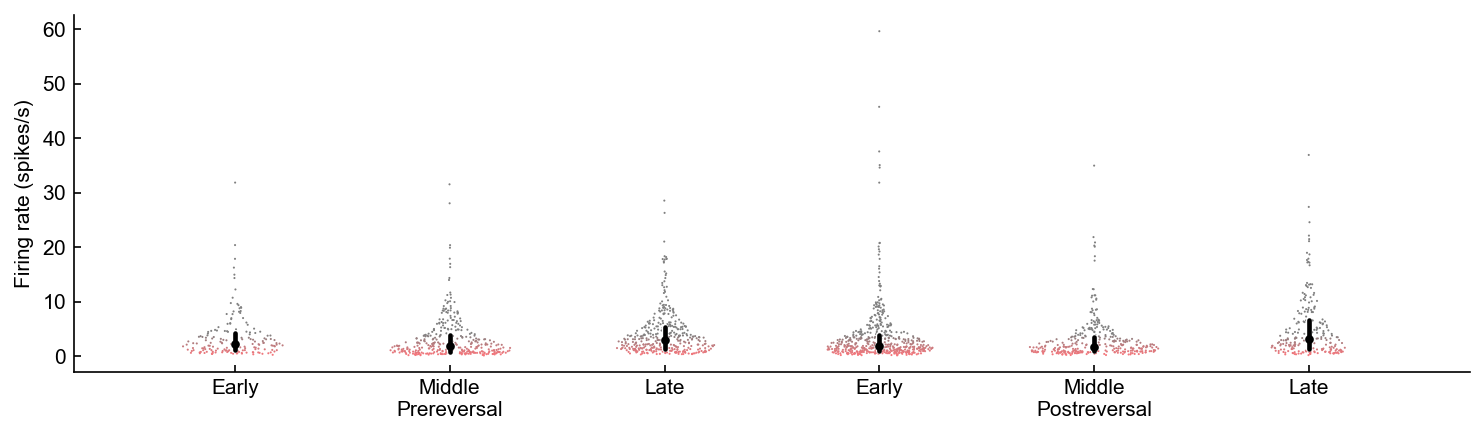

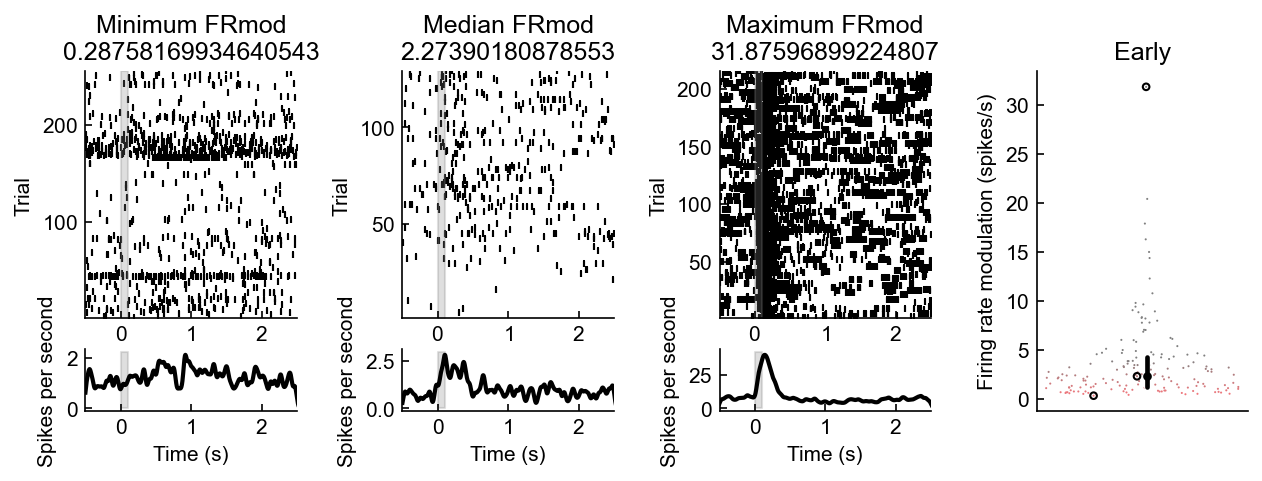

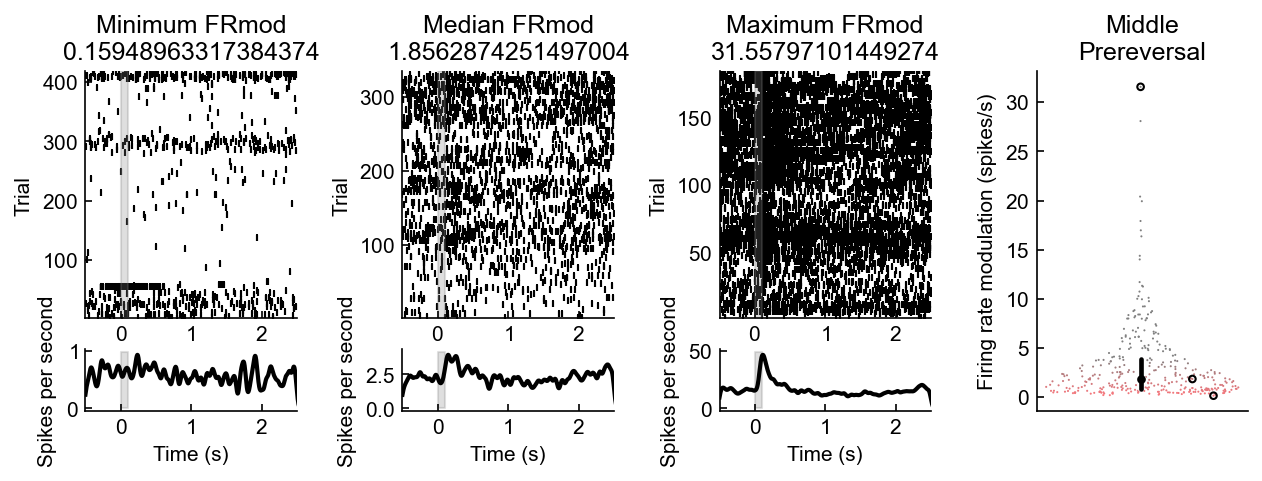

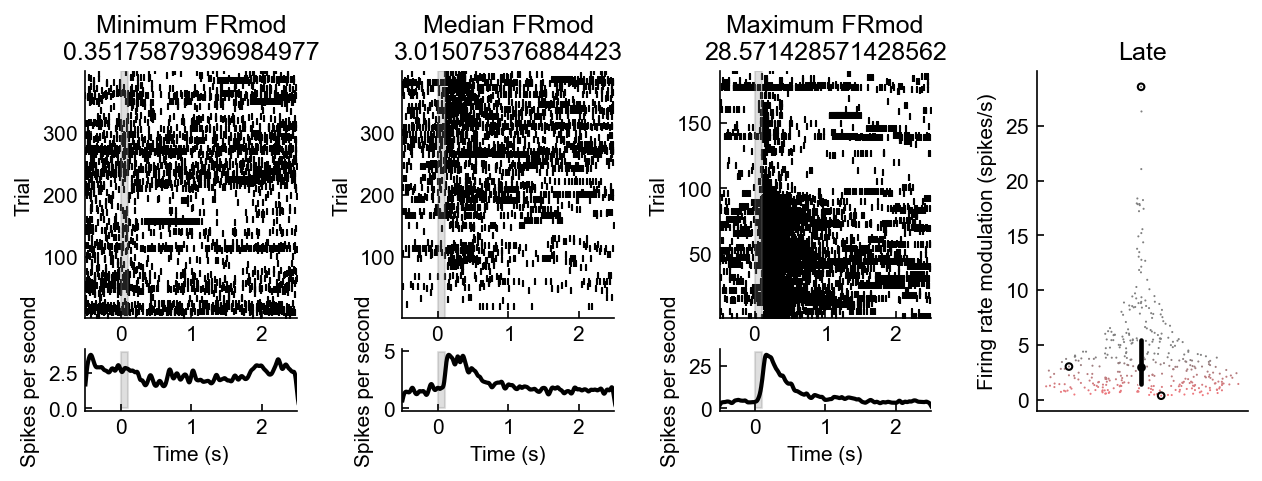

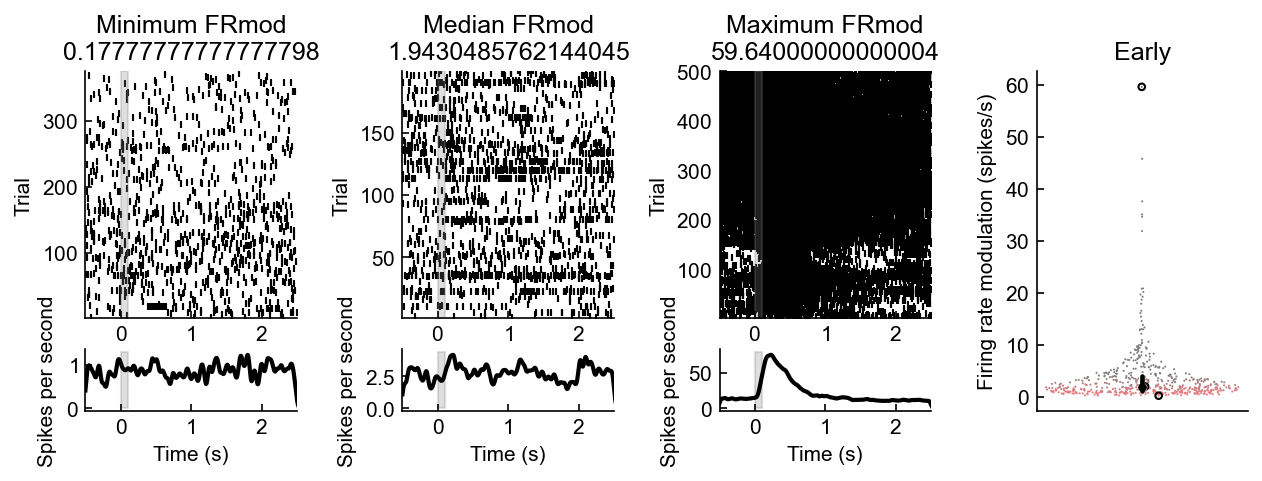

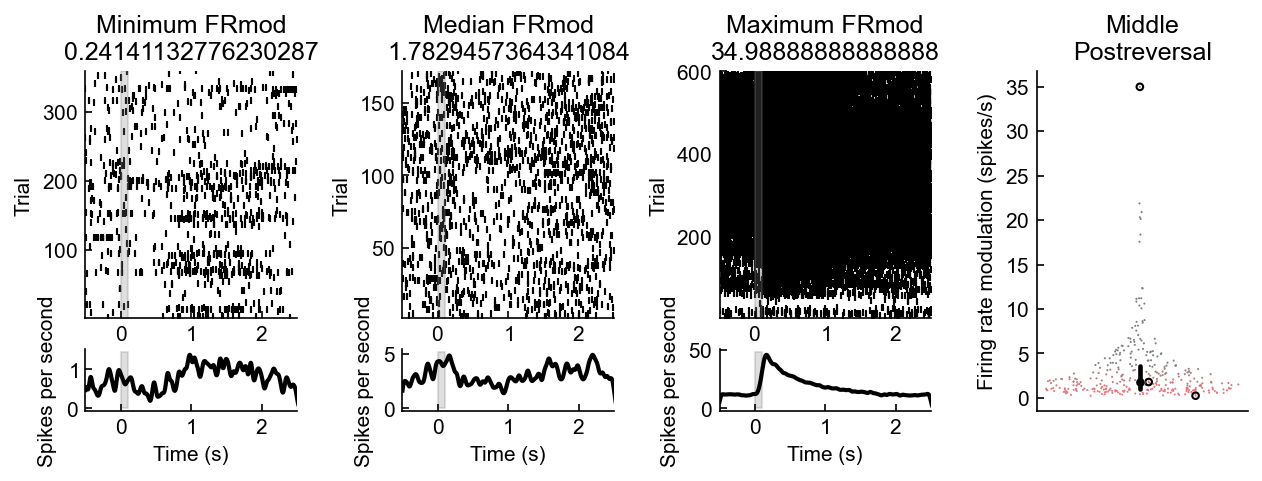

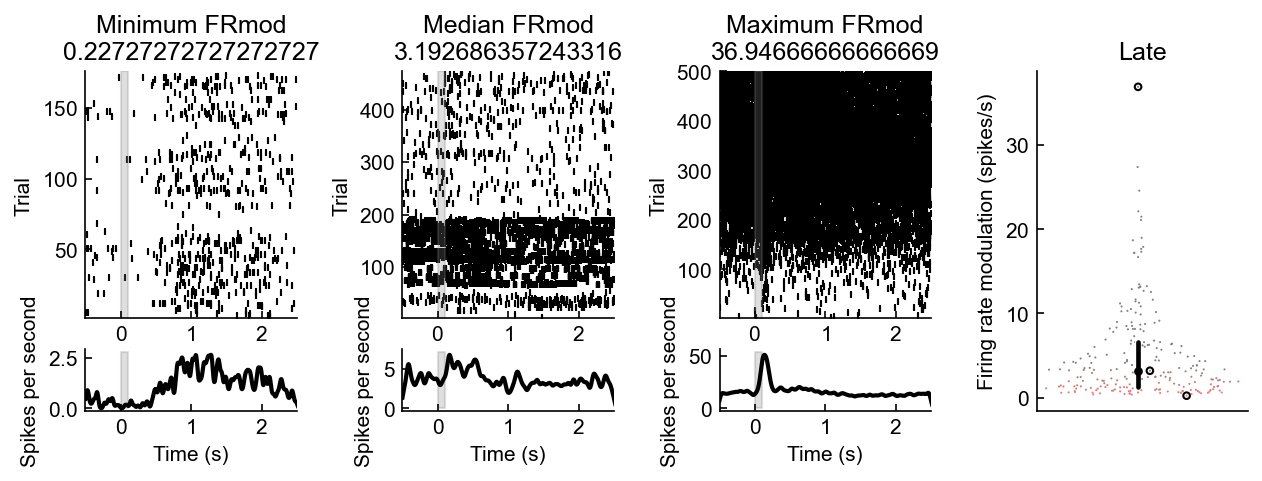

In [34]:
labels = ['Early','Middle\nPrereversal','Late','Early','Middle\nPostreversal','Late']
statlabels = ['Early Prereversal','Middle Prereversal','Late Prereversal','Early Postreversal','Middle Postreversal','Late Postreversal']
dataToUse = [preEarly,preMid,preLate,postEarly,postMid,postLate]
sessionsToUse = [preEarlySess,preMidSess,preLateSess,postEarlySess,postMidSess,postLateSess]
idsToUse = [preEarlyClust,preMidClust,preLateClust,postEarlyClust,postMidClust,postLateClust]

bandwidth = 'scott'
total=1.0
width = 3
size=1
#color='k'
highlights = []
scale_factor = 1.0
trans = 1

fig, ax = plt.subplots(figsize=(10,3))
for idx,column in enumerate(dataToUse):
    column = column[np.logical_not(np.isnan(column))]
    f_density = gaussian_kde(column, bw_method=bandwidth)
    X_plot = scale_factor * f_density(column) * (np.random.rand(len(column)) -.5) * width + idx
    
    color=NCR_CR_cmap(column/4)
    
    ax.scatter(X_plot, column, s=size, c=color, zorder=0, alpha=trans, lw=0)
    
    #Highlight units
    if len(highlights) > 0:
        ax.scatter(X_plot[highlights], column[highlights], s=size*2, color='k', marker=highlight_marker, facecolors='none')
        
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim([-0.75,5.75])
        
print('Significances (Bonferroni corrected)')
MCfactor = 15 # Multiple comparisons factor
for idx,column in enumerate(dataToUse):
    for idxx,column2 in enumerate(dataToUse):
        if idx!=idxx:
            column = column[~np.isnan(column)]
            column2 = column2[~np.isnan(column2)]
            pval = mannwhitneyu(column,column2).pvalue
            if pval <=0.0001 / MCfactor:
                print('**** ' + statlabels[idx] + ' - ' + statlabels[idxx] + ' : ' + str(pval))
            elif pval <=0.001 / MCfactor:
                print('***  ' + statlabels[idx] + ' - ' + statlabels[idxx] + ' : ' + str(pval))
            elif pval <=0.01 / MCfactor:
                print('**   ' + statlabels[idx] + ' - ' + statlabels[idxx] + ' : ' + str(pval))
            elif pval <=0.05 / MCfactor:
                print('*    ' + statlabels[idx] + ' - ' + statlabels[idxx] + ' : ' + str(pval))
            else:
                print('     ' + statlabels[idx] + ' - ' + statlabels[idxx] + ' : ' + str(pval))
    
plt.tight_layout()
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries','Responsiveness Over Training.pdf'),transparent=False,facecolor="white")





for idx,column in enumerate(dataToUse):
    
    fig = plt.figure(figsize=(10,3))
    gs = fig.add_gridspec(2,4,height_ratios=[4,1],hspace=0.2,wspace=0.5)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax3 = plt.subplot(gs[0,1])#Raster
    ax4 = plt.subplot(gs[1,1],sharex=ax1)#PSTH
    ax5 = plt.subplot(gs[0,2])#Raster
    ax6 = plt.subplot(gs[1,2],sharex=ax1)#PSTH
    ax7 = plt.subplot(gs[:,3])
    
    sesss = sessionsToUse[idx]
    ids = idsToUse[idx]
    sesss = sesss[np.logical_not(np.isnan(column))]
    ids = ids[np.logical_not(np.isnan(column))]
    column = column[np.logical_not(np.isnan(column))]
    idxmin = np.where(column == np.min(column))[0][0]
    #Calculating the median requires some extra work because median's behavior is different for even length arrays
    temp = np.sort(column)
    temp = temp[int(len(temp)/2)]
    idxmedian = np.where(column == temp)[0][0]
    idxmax = np.where(column == np.max(column))[0][0]
    
    highlights = [idxmin,idxmedian,idxmax]    
    plotUnitGivenAx(ax1,ax2,ilep.loadSessionCached(directory,sesss[idxmin]),ids[idxmin])
    plotUnitGivenAx(ax3,ax4,ilep.loadSessionCached(directory,sesss[idxmedian]),ids[idxmedian])
    plotUnitGivenAx(ax5,ax6,ilep.loadSessionCached(directory,sesss[idxmax]),ids[idxmax])

    f_density = gaussian_kde(column, bw_method=bandwidth)
    X_plot = scale_factor * f_density(column) * (np.random.rand(len(column)) -.5) * width + 0
    
    color=NCR_CR_cmap(column/4)
    
    ax7.scatter(X_plot, column, s=size, c=color, zorder=0, alpha=trans, lw=0)
    if len(highlights) > 0:
        ax7.scatter(X_plot[highlights], column[highlights], s=size*10, color='k', marker='o', facecolors='none')
    ax7.set_xticks([])
    
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax7.scatter([0], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax7.scatter([0], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax7.plot([0, 0], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax7.plot([0, 0], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')
        
    ax7.set_ylabel('Firing rate modulation (spikes/s)')
    ax1.set_title('Minimum FRmod\n'+str(ilep.loadSessionCached(directory,sesss[idxmin]).responsiveness[ids[idxmin]]['all_trials'].FRmodulation))
    ax3.set_title('Median FRmod\n'+str(ilep.loadSessionCached(directory,sesss[idxmedian]).responsiveness[ids[idxmedian]]['all_trials'].FRmodulation))
    ax5.set_title('Maximum FRmod\n'+str(ilep.loadSessionCached(directory,sesss[idxmax]).responsiveness[ids[idxmax]]['all_trials'].FRmodulation))
    ax7.set_title(labels[idx])
    
    
    
    print(labels[idx])
    print('Min    :'+sesss[idxmin]+' '+str(ids[idxmin]))
    print('Median :'+sesss[idxmedian]+' '+str(ids[idxmedian]))
    print('Max    :'+sesss[idxmax]+' '+str(ids[idxmax]))
    
    plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',statlabels[idx] + ' responsiveness.pdf'),transparent=False,facecolor="white")

M2 significances (Bonferroni corrected)
     Early Pre-reversal - Middle Pre-reversal : 0.02125083313959523
     Early Pre-reversal - Late Pre-reversal : 0.004770316366388841
     Early Pre-reversal - Early Post-reversal : 0.2184671485223043
     Early Pre-reversal - Middle Post-reversal : 0.025358460965629
     Early Pre-reversal - Late Post-reversal : 0.004317912843739247
     Middle Pre-reversal - Early Pre-reversal : 0.02125083313959523
**** Middle Pre-reversal - Late Pre-reversal : 3.298594250653608e-08
     Middle Pre-reversal - Early Post-reversal : 0.029631297829943833
     Middle Pre-reversal - Middle Post-reversal : 0.37322499103137274
**** Middle Pre-reversal - Late Post-reversal : 3.393983865078186e-07
     Late Pre-reversal - Early Pre-reversal : 0.004770316366388841
**** Late Pre-reversal - Middle Pre-reversal : 3.298594250653597e-08
**** Late Pre-reversal - Early Post-reversal : 4.888372686911725e-06
**** Late Pre-reversal - Middle Post-reversal : 9.748586347352254e-09
 

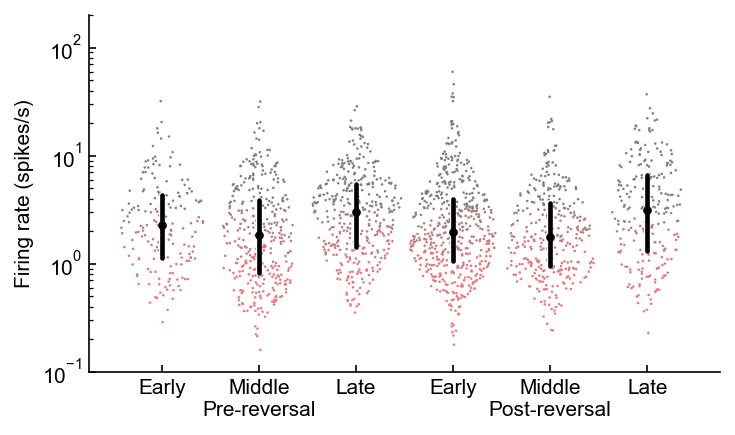

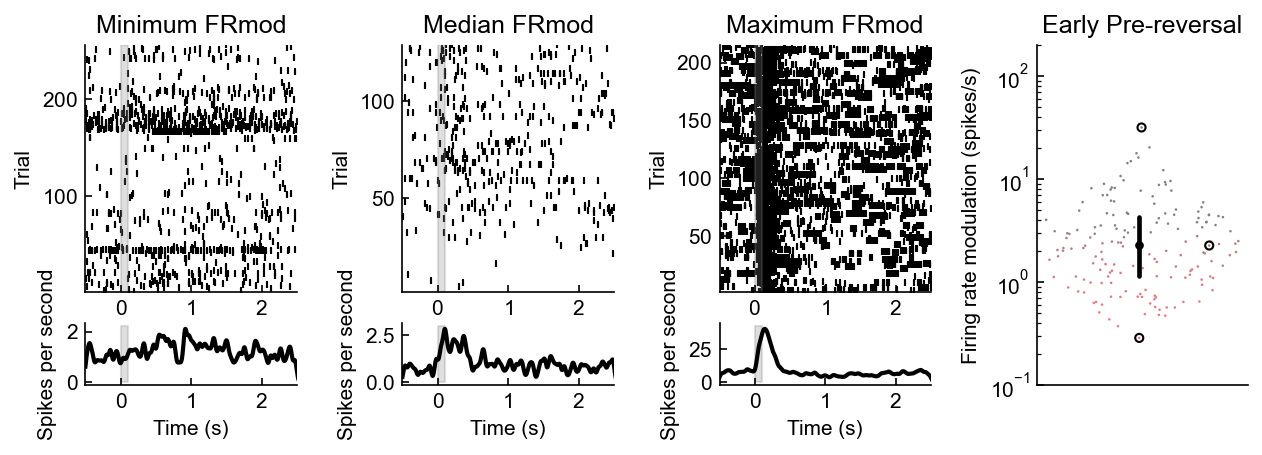

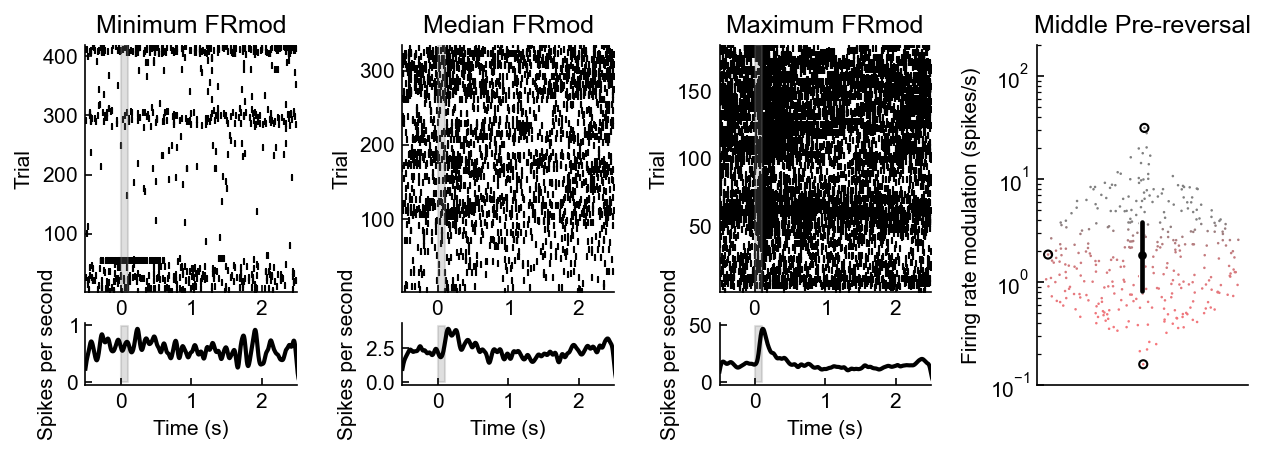

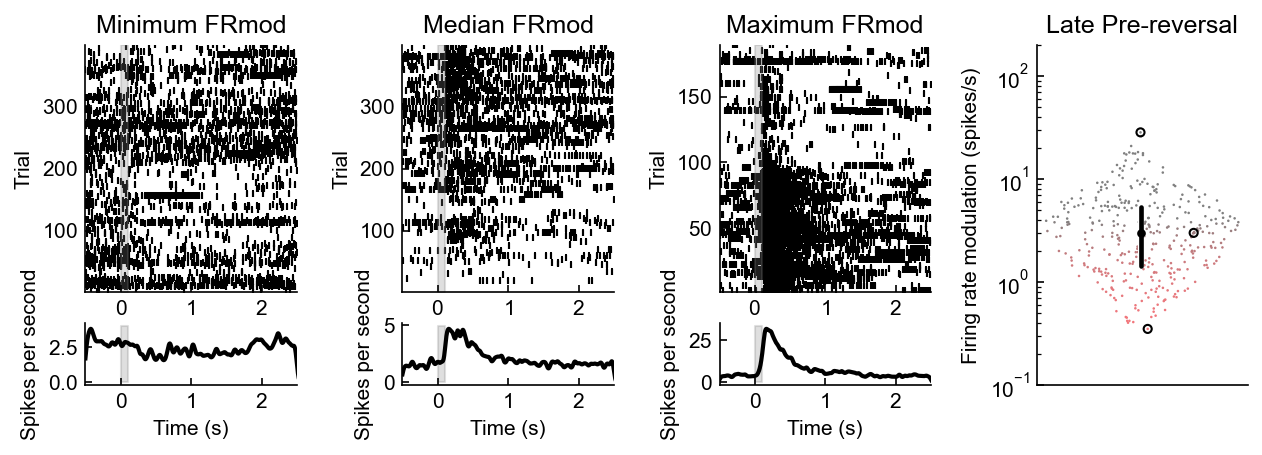

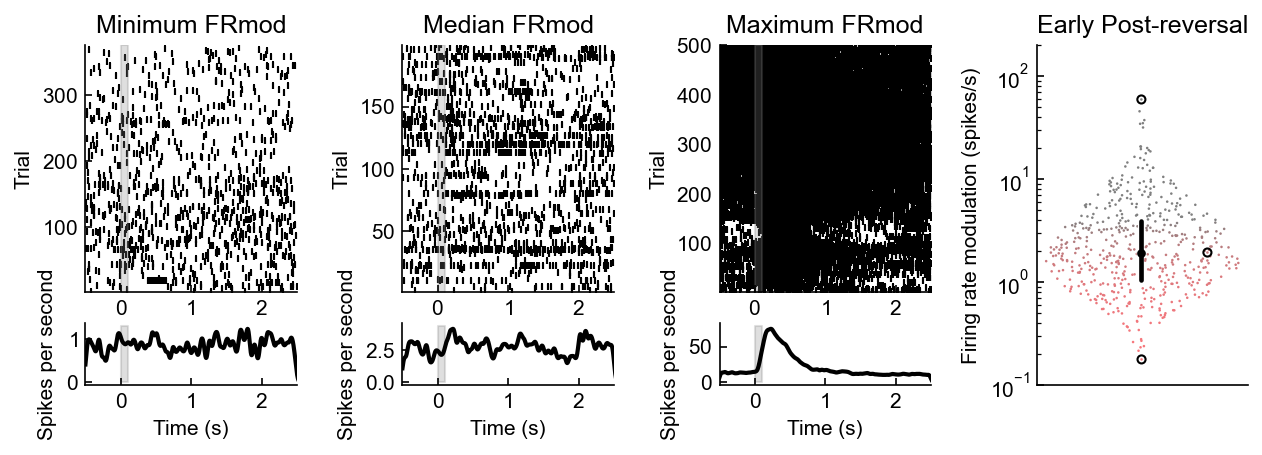

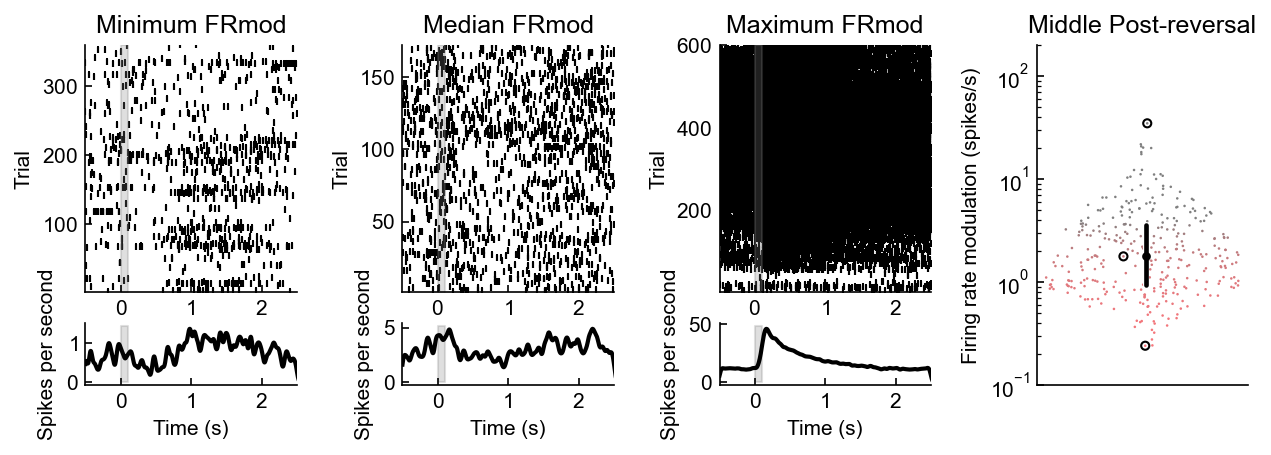

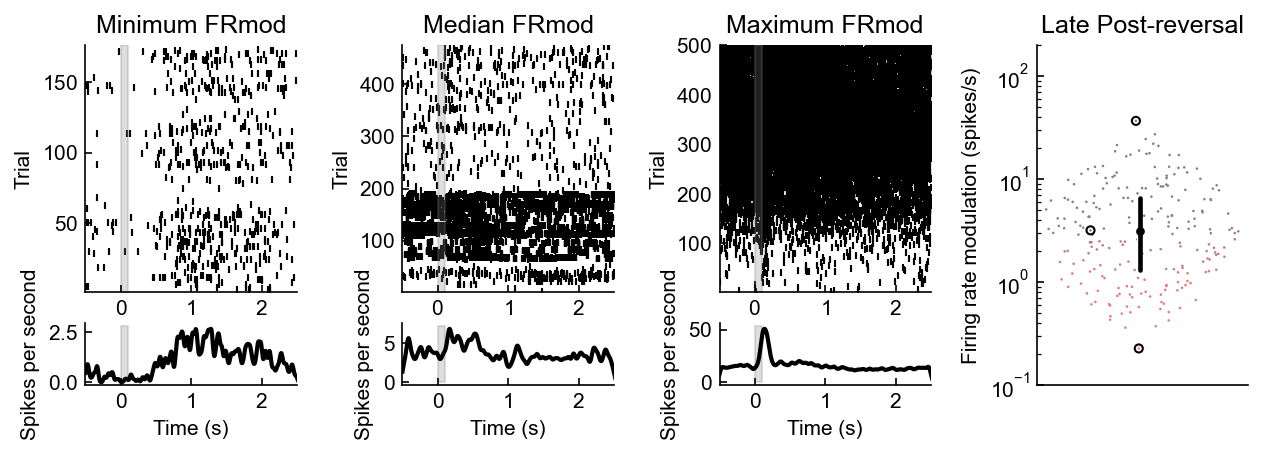

In [45]:
labels = ['Early','Middle\nPre-reversal','Late','Early','Middle\nPost-reversal','Late']
statlabels = ['Early Pre-reversal','Middle Pre-reversal','Late Pre-reversal','Early Post-reversal','Middle Post-reversal','Late Post-reversal']
dataToUse = [preEarly,preMid,preLate,postEarly,postMid,postLate]
sessionsToUse = [preEarlySess,preMidSess,preLateSess,postEarlySess,postMidSess,postLateSess]
idsToUse = [preEarlyClust,preMidClust,preLateClust,postEarlyClust,postMidClust,postLateClust]

bandwidth = 'scott'
total=1.0
width = 1
size=1.5
#color='k'
highlights = []
scale_factor = 1.0
trans = 1

fig, ax = plt.subplots(figsize=(5,3))
for idx,column in enumerate(dataToUse):
    colorcolumn = column
    
    column = column[np.logical_not(np.isnan(column))]
    f_density = gaussian_kde(np.log10(column), bw_method=bandwidth)
    X_plot = scale_factor * f_density(np.log10(column)) * (np.random.rand(len(column)) -.5) * width + idx
    
    color=NCR_CR_cmap(colorcolumn/4)
    
    ax.scatter(X_plot, column, s=size, c=color, zorder=0, alpha=trans, lw=0)
    
    #Highlight units
    if len(highlights) > 0:
        ax.scatter(X_plot[highlights], column[highlights], s=size*2, color='k', marker=highlight_marker, facecolors='none')
        
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')
    
    ax.set_yscale('log',base=10)
    ax.set_ylim([0.1,200])

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim([-0.75,5.75])
        
print(reg+' significances (Bonferroni corrected)')
MCfactor = 15 # Multiple comparisons factor
for idx,column in enumerate(dataToUse):
    for idxx,column2 in enumerate(dataToUse):
        if idx!=idxx:
            column = column[~np.isnan(column)]
            column2 = column2[~np.isnan(column2)]
            pval = mannwhitneyu(column,column2).pvalue
            if pval <=0.0001 / MCfactor:
                print('**** ' + statlabels[idx] + ' - ' + statlabels[idxx] + ' : ' + str(pval))
            elif pval <=0.001 / MCfactor:
                print('***  ' + statlabels[idx] + ' - ' + statlabels[idxx] + ' : ' + str(pval))
            elif pval <=0.01 / MCfactor:
                print('**   ' + statlabels[idx] + ' - ' + statlabels[idxx] + ' : ' + str(pval))
            elif pval <=0.05 / MCfactor:
                print('*    ' + statlabels[idx] + ' - ' + statlabels[idxx] + ' : ' + str(pval))
            else:
                print('     ' + statlabels[idx] + ' - ' + statlabels[idxx] + ' : ' + str(pval))
    
plt.tight_layout()
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' Log responsiveness Over Training.pdf'),transparent=False,facecolor="white")





for idx,column in enumerate(dataToUse):
    colorcolumn = column
    #column = np.log(column)
    
    fig = plt.figure(figsize=(10,3))
    gs = fig.add_gridspec(2,4,height_ratios=[4,1],hspace=0.2,wspace=0.5)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax3 = plt.subplot(gs[0,1])#Raster
    ax4 = plt.subplot(gs[1,1],sharex=ax1)#PSTH
    ax5 = plt.subplot(gs[0,2])#Raster
    ax6 = plt.subplot(gs[1,2],sharex=ax1)#PSTH
    ax7 = plt.subplot(gs[:,3])
    
    sesss = sessionsToUse[idx]
    ids = idsToUse[idx]
    sesss = sesss[np.logical_not(np.isnan(column))]
    ids = ids[np.logical_not(np.isnan(column))]
    column = column[np.logical_not(np.isnan(column))]
    idxmin = np.where(column == np.min(column))[0][0]
    #Calculating the median requires some extra work because median's behavior is different for even length arrays
    temp = np.sort(column)
    temp = temp[int(len(temp)/2)]
    idxmedian = np.where(column == temp)[0][0]
    idxmax = np.where(column == np.max(column))[0][0]
    
    highlights = [idxmin,idxmedian,idxmax]    
    plotUnitGivenAx(ax1,ax2,ilep.loadSessionCached(directory,sesss[idxmin]),ids[idxmin])
    plotUnitGivenAx(ax3,ax4,ilep.loadSessionCached(directory,sesss[idxmedian]),ids[idxmedian])
    plotUnitGivenAx(ax5,ax6,ilep.loadSessionCached(directory,sesss[idxmax]),ids[idxmax])

    f_density = gaussian_kde(np.log10(column), bw_method=bandwidth)
    X_plot = scale_factor * f_density(np.log10(column)) * (np.random.rand(len(column)) -.5) * width + 0
    
    color=NCR_CR_cmap(colorcolumn/4)
    
    ax7.scatter(X_plot, column, s=size, c=color, zorder=0, alpha=trans, lw=0)
    if len(highlights) > 0:
        ax7.scatter(X_plot[highlights], column[highlights], s=size*10, color='k', marker='o', facecolors='none')
    ax7.set_xticks([])
    ax7.set_yscale('log',base=10)
    ax7.set_ylim([0.1,200])
    
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax7.scatter([0], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax7.scatter([0], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax7.plot([0, 0], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax7.plot([0, 0], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')
        
    ax7.set_ylabel('Firing rate modulation (spikes/s)')
    ax1.set_title('Minimum FRmod')
    ax3.set_title('Median FRmod')
    ax5.set_title('Maximum FRmod')
    ax7.set_title(statlabels[idx])
    
    
    print(labels[idx])
    print('Min    :'+sesss[idxmin]+' '+str(ids[idxmin]))
    print('Median :'+sesss[idxmedian]+' '+str(ids[idxmedian]))
    print('Max    :'+sesss[idxmax]+' '+str(ids[idxmax]))
    
    plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',statlabels[idx] + ' '+reg+' log responsiveness with examples.pdf'),transparent=False,facecolor="white")

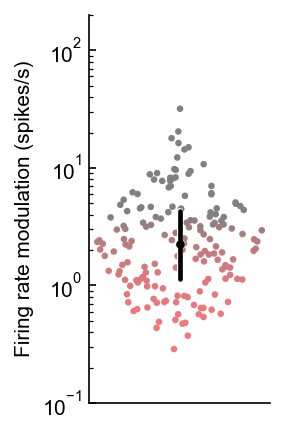

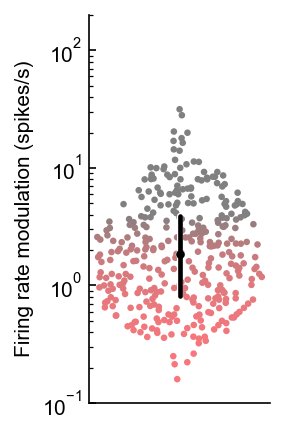

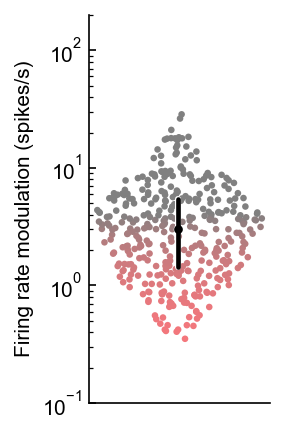

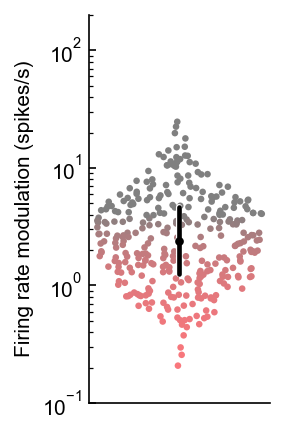

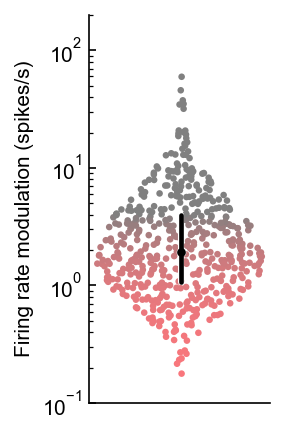

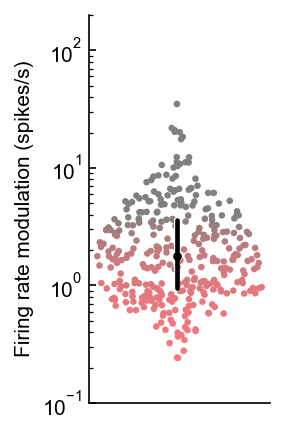

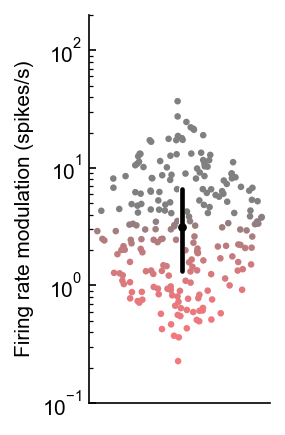

In [36]:
labels = ['Early','Middle\nPre-reversal','Late','Switch','Early','Middle\nPost-reversal','Late']
statlabels = ['Early Pre-reversal','Middle Pre-reversal','Late Pre-reversal','Switch','Early Post-reversal','Middle Post-reversal','Late Post-reversal']
dataToUse = [preEarly,preMid,preLate,switch,postEarly,postMid,postLate]
sessionsToUse = [preEarlySess,preMidSess,preLateSess,switchSess,postEarlySess,postMidSess,postLateSess]
idsToUse = [preEarlyClust,preMidClust,preLateClust,switchClust,postEarlyClust,postMidClust,postLateClust]

bandwidth = 'scott'
total=1.0
width = 1
size=10
#color='k'
highlights = []
scale_factor = 1.0
trans = 1

for idx,column in enumerate(dataToUse):
    colorcolumn = column
    #column = np.log(column)
    
    f_density = gaussian_kde(np.log10(column), bw_method=bandwidth)
    X_plot = scale_factor * f_density(np.log10(column)) * (np.random.rand(len(column)) -.5) * width + 0
    
    color=NCR_CR_cmap(colorcolumn/4)
    
    #Plot figure on its own
    fig,ax = plt.subplots(figsize=(2,3))
    ax.scatter(X_plot, column, s=size, c=color, zorder=0, alpha=trans, lw=0)
    ax.set_xticks([])
    ax.set_yscale('log',base=10)
    ax.set_ylim([0.1,200])
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([0], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([0], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([0, 0], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([0, 0], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')
    ax.set_ylabel('Firing rate modulation (spikes/s)')
    
    plt.tight_layout()
    plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',statlabels[idx] +' '+reg+' log responsiveness.pdf'),transparent=False,facecolor="white")

[ 0.43478261 10.91954023  0.4         2.43902439 12.12121212 13.92156863]


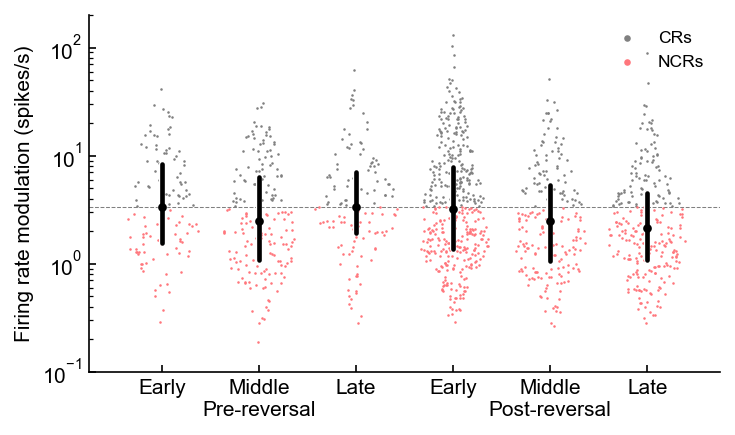

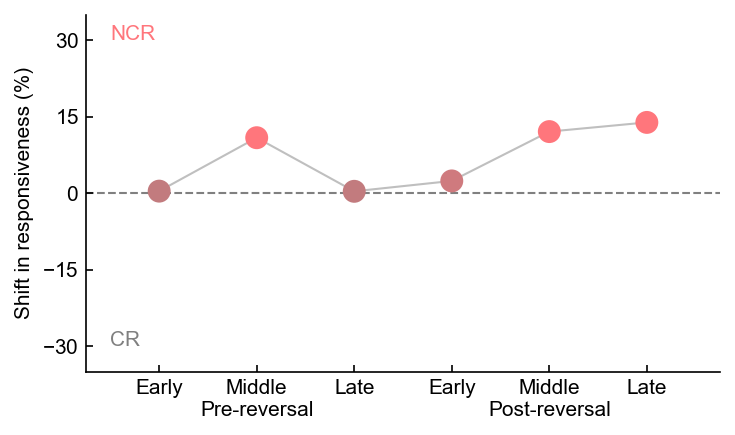

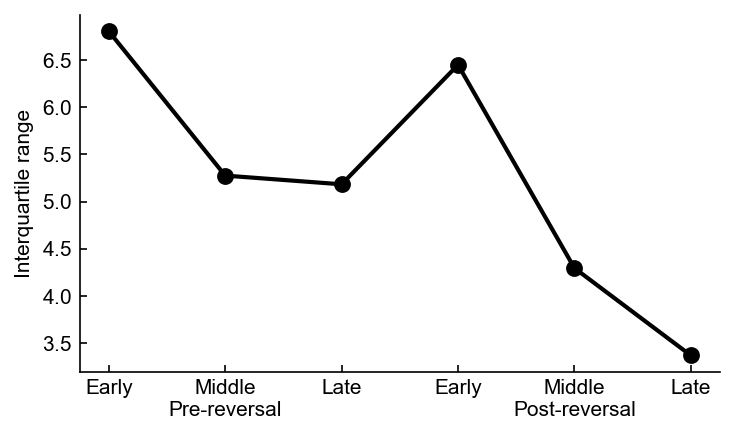

In [137]:
labels = ['Early','Middle\nPre-reversal','Late','Early','Middle\nPost-reversal','Late']
statlabels = ['Early Pre-reversal','Middle Pre-reversal','Late Pre-reversal','Early Post-reversal','Middle Post-reversal','Late Post-reversal']
dataToUse = [preEarly,preMid,preLate,postEarly,postMid,postLate]
sessionsToUse = [preEarlySess,preMidSess,preLateSess,postEarlySess,postMidSess,postLateSess]
idsToUse = [preEarlyClust,preMidClust,preLateClust,postEarlyClust,postMidClust,postLateClust]

#labels = ['Pre','Post']
#statlabels = ['Pre-Exp','Post-Exp']
#dataToUse = [preLate,postLate]

#labels = ['Late\nPre-reversal','Early','Intermediate\nPost-reversal','Late']
#statlabels = ['Late Pre-reversal','Early Post-reversal','Intermediate Post-reversal','Late Post-reversal']
#dataToUse = [preLate,postEarly,postMid,postLate]
#sessionsToUse = [preLateSess,postEarlySess,postMidSess,postLateSess]
#idsToUse = [preLateClust,postEarlyClust,postMidClust,postLateClust]

#labels = ['Early','Intermediate\nPre-reversal','Late']
#statlabels = ['Early Pre-reversal','Intermediate Pre-reversal','Late Pre-reversal']
#dataToUse = [preEarly,preMid,preLate]
#sessionsToUse = [preEarlySess,preMidSess,preLateSess]
#idsToUse = [preEarlyClust,preMidClust,preLateClust]

numCon = len(dataToUse)

#baselinemedian = np.median(preLate)
baselinemedian = np.median(preEarly)
#baselinemedian = 3.3782569631626256
bandwidth = 'scott'
total=1.0
width = 1
size=1.5
#color='k'
highlights = []
scale_factor = 1.0
trans = 1

fig, ax = plt.subplots(figsize=(5,3))
for idx,column in enumerate(dataToUse):
    column = column[np.isfinite(column)]
    
    f_density = gaussian_kde(np.log10(column), bw_method=bandwidth)
    X_plot = scale_factor * f_density(np.log10(column)) * (np.random.rand(len(column)) -.5) * width + idx
    
    CRidx = np.greater_equal(column,baselinemedian)
    ax.scatter(X_plot[CRidx], column[CRidx], s=size, c=CR_COLOR, zorder=0, alpha=trans, lw=0)
    NCRidx = np.logical_not(CRidx)
    ax.scatter(X_plot[NCRidx], column[NCRidx], s=size, c=NCR_COLOR, zorder=0, alpha=trans, lw=0)
        
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')
    
    ax.set_yscale('log',base=10)
    ax.set_ylim([0.1,200])

ax.set_ylabel('Firing rate modulation (spikes/s)')
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
xlims = [-0.75,numCon-0.25]
ax.set_xlim(xlims)
ax.plot(xlims,[baselinemedian,baselinemedian],'grey',linestyle='--',lw=0.5,zorder=-10)

ax.scatter([],[], s=10, c=CR_COLOR, zorder=0, lw=0, label='CRs')
ax.scatter([],[], s=10, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
ax.legend(frameon=False,loc='upper right')
    
plt.tight_layout()
#plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' New CR-NCR Over Training.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' CR-NCR Over Training.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' CR-NCR Over Prereversal Training.pdf'),transparent=False,facecolor="white")

##############################################################################################################################################################################

fig, ax = plt.subplots(figsize=(5,3))
percentCR = np.zeros(numCon)
for idx,column in enumerate(dataToUse):
    column = column[np.logical_not(np.isnan(column))]
    percentCR[idx] = np.mean(np.greater(column,baselinemedian))*100
ax.plot(range(numCon),-(percentCR-50),color='grey',lw=1,alpha=0.5)
print(-(percentCR-50))
#12.12121212

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),-(percentCR-50),c=color,s=100,zorder=10)

xlims = [-0.75,numCon-0.25]
ax.plot(xlims,[0,0],c='grey',linestyle='--',lw=1,zorder=-10)
ax.set_xlim(xlims)
if reg=='AC':
    #ax.set_ylim([-35,5])
    #ax.set_yticks([-30,-20,-10,0])
    ax.set_ylim([-35,35])
    ax.set_yticks([-30,-15,0,15,30])
elif reg == 'M2':
    #ax.set_ylim([-15,15])
    #ax.set_yticks([-15,-10,-5,0,5,10,15])
    #ax.set_ylim([-25,15])
    #ax.set_ylim([-25,5])
    #ax.set_yticks([-20,-10,0])
    ax.set_ylim([-35,35])
    ax.set_yticks([-30,-15,0,15,30])
    pass


ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

ax.set_ylabel('Shift in responsiveness (%)')
if reg == 'AC':
    ax.text(-0.5,30,'NCR',color=NCR_COLOR)
    #ax.text(-0.5,5,'CR',color=CR_COLOR)
    ax.text(-0.5,-30,'CR',color=CR_COLOR)
elif reg == 'M2':
    ax.text(-0.5,30,'NCR',color=NCR_COLOR)
    #ax.text(-0.5,-5,'CR',color=CR_COLOR)
    ax.text(-0.5,-30,'CR',color=CR_COLOR)
plt.tight_layout()
#plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' Shift in Responsiveness Over Training.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' Shift in Responsiveness Over Prereversal Training.pdf'),transparent=False,facecolor="white")

##############################################################################################################################################################################

fig, ax = plt.subplots(figsize=(5,3))
IQRs = np.zeros(numCon)
for idx,column in enumerate(dataToUse):
    column = column[np.logical_not(np.isnan(column))]
    IQRs[idx] = iqr(column)
ax.plot(range(numCon),IQRs,color='k',lw=2)
ax.scatter(range(numCon),IQRs,c='k',s=50)

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

ax.set_ylabel('Interquartile range')
plt.tight_layout()
#plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' IQR Over Training.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' IQR Over Prereversal Training.pdf'),transparent=False,facecolor="white")

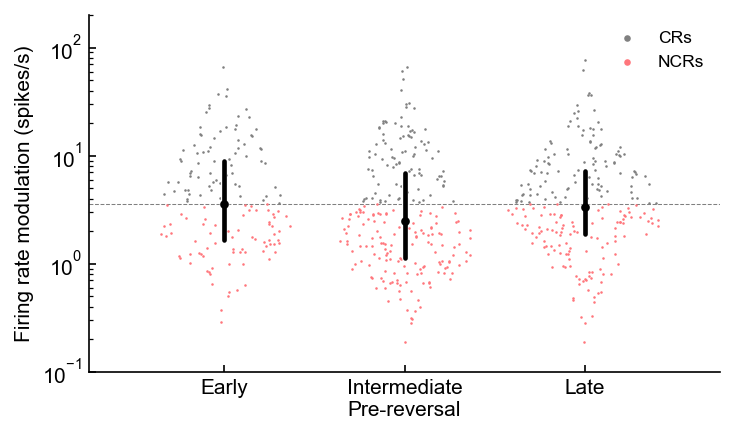

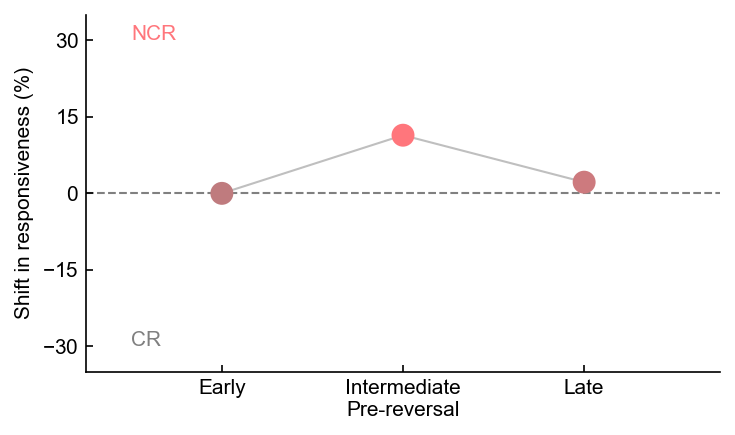

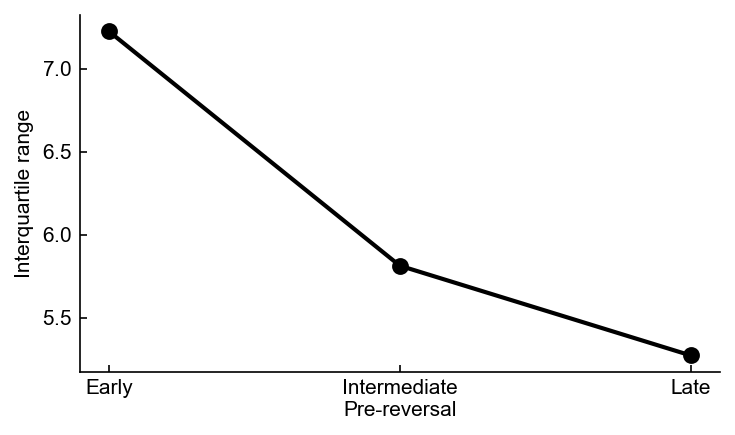

In [18]:
#labels = ['Early','Middle\nPre-reversal','Late','Early','Middle\nPost-reversal','Late']
#statlabels = ['Early Pre-reversal','Middle Pre-reversal','Late Pre-reversal','Early Post-reversal','Middle Post-reversal','Late Post-reversal']
#dataToUse = [preEarly,preMid,preLate,postEarly,postMid,postLate]
#sessionsToUse = [preEarlySess,preMidSess,preLateSess,postEarlySess,postMidSess,postLateSess]
#idsToUse = [preEarlyClust,preMidClust,preLateClust,postEarlyClust,postMidClust,postLateClust]

#labels = ['Late\nPre-reversal','Early','Intermediate\nPost-reversal','Late']
#statlabels = ['Late Pre-reversal','Early Post-reversal','Intermediate Post-reversal','Late Post-reversal']
#dataToUse = [preLate,postEarly,postMid,postLate]
#sessionsToUse = [preLateSess,postEarlySess,postMidSess,postLateSess]
#idsToUse = [preLateClust,postEarlyClust,postMidClust,postLateClust]

labels = ['Early','Intermediate\nPre-reversal','Late']
statlabels = ['Early Pre-reversal','Intermediate Pre-reversal','Late Pre-reversal']
dataToUse = [preEarly,preMid,preLate]
sessionsToUse = [preEarlySess,preMidSess,preLateSess]
idsToUse = [preEarlyClust,preMidClust,preLateClust]

numCon = len(dataToUse)

#baselinemedian = np.median(preLate)
baselinemedian = np.median(preEarly)
bandwidth = 'scott'
total=1.0
width = 1
size=1.5
#color='k'
highlights = []
scale_factor = 1.0
trans = 1

fig, ax = plt.subplots(figsize=(5,3))
for idx,column in enumerate(dataToUse):
    column = column[np.isfinite(column)]
    
    f_density = gaussian_kde(np.log10(column), bw_method=bandwidth)
    X_plot = scale_factor * f_density(np.log10(column)) * (np.random.rand(len(column)) -.5) * width + idx
    
    CRidx = np.greater_equal(column,baselinemedian)
    ax.scatter(X_plot[CRidx], column[CRidx], s=size, c=CR_COLOR, zorder=0, alpha=trans, lw=0)
    NCRidx = np.logical_not(CRidx)
    ax.scatter(X_plot[NCRidx], column[NCRidx], s=size, c=NCR_COLOR, zorder=0, alpha=trans, lw=0)
        
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')
    
    ax.set_yscale('log',base=10)
    ax.set_ylim([0.1,200])

ax.set_ylabel('Firing rate modulation (spikes/s)')
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
xlims = [-0.75,numCon-0.25]
ax.set_xlim(xlims)
ax.plot(xlims,[baselinemedian,baselinemedian],'grey',linestyle='--',lw=0.5,zorder=-10)

ax.scatter([],[], s=10, c=CR_COLOR, zorder=0, lw=0, label='CRs')
ax.scatter([],[], s=10, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
ax.legend(frameon=False,loc='upper right')
    
plt.tight_layout()
#plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' CR-NCR Over Training.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' CR-NCR Over Prereversal Training.pdf'),transparent=False,facecolor="white")

##############################################################################################################################################################################

fig, ax = plt.subplots(figsize=(5,3))
percentCR = np.zeros(numCon)
for idx,column in enumerate(dataToUse):
    column = column[np.logical_not(np.isnan(column))]
    percentCR[idx] = np.mean(np.greater(column,baselinemedian))*100
ax.plot(range(numCon),-(percentCR-50),color='grey',lw=1,alpha=0.5)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),-(percentCR-50),c=color,s=100,zorder=10)

xlims = [-0.75,numCon-0.25]
ax.plot(xlims,[0,0],c='grey',linestyle='--',lw=1,zorder=-10)
ax.set_xlim(xlims)
if reg=='AC':
    #ax.set_ylim([-35,5])
    #ax.set_yticks([-30,-20,-10,0])
    ax.set_ylim([-35,35])
    ax.set_yticks([-30,-15,0,15,30])
elif reg == 'M2':
    #ax.set_ylim([-15,15])
    #ax.set_yticks([-15,-10,-5,0,5,10,15])
    #ax.set_ylim([-25,15])
    #ax.set_ylim([-25,5])
    #ax.set_yticks([-20,-10,0])
    ax.set_ylim([-35,35])
    ax.set_yticks([-30,-15,0,15,30])
    pass

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

ax.set_ylabel('Shift in responsiveness (%)')
if reg == 'AC':
    ax.text(-0.5,30,'NCR',color=NCR_COLOR)
    #ax.text(-0.5,5,'CR',color=CR_COLOR)
    ax.text(-0.5,-30,'CR',color=CR_COLOR)
elif reg == 'M2':
    ax.text(-0.5,30,'NCR',color=NCR_COLOR)
    #ax.text(-0.5,-5,'CR',color=CR_COLOR)
    ax.text(-0.5,-30,'CR',color=CR_COLOR)
plt.tight_layout()
#plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' Shift in Responsiveness Over Training.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' Shift in Responsiveness Over Prereversal Training.pdf'),transparent=False,facecolor="white")

##############################################################################################################################################################################

fig, ax = plt.subplots(figsize=(5,3))
IQRs = np.zeros(numCon)
for idx,column in enumerate(dataToUse):
    column = column[np.logical_not(np.isnan(column))]
    IQRs[idx] = iqr(column)
ax.plot(range(numCon),IQRs,color='k',lw=2)
ax.scatter(range(numCon),IQRs,c='k',s=50)

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

ax.set_ylabel('Interquartile range')
plt.tight_layout()
#plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' IQR Over Training.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' IQR Over Prereversal Training.pdf'),transparent=False,facecolor="white")

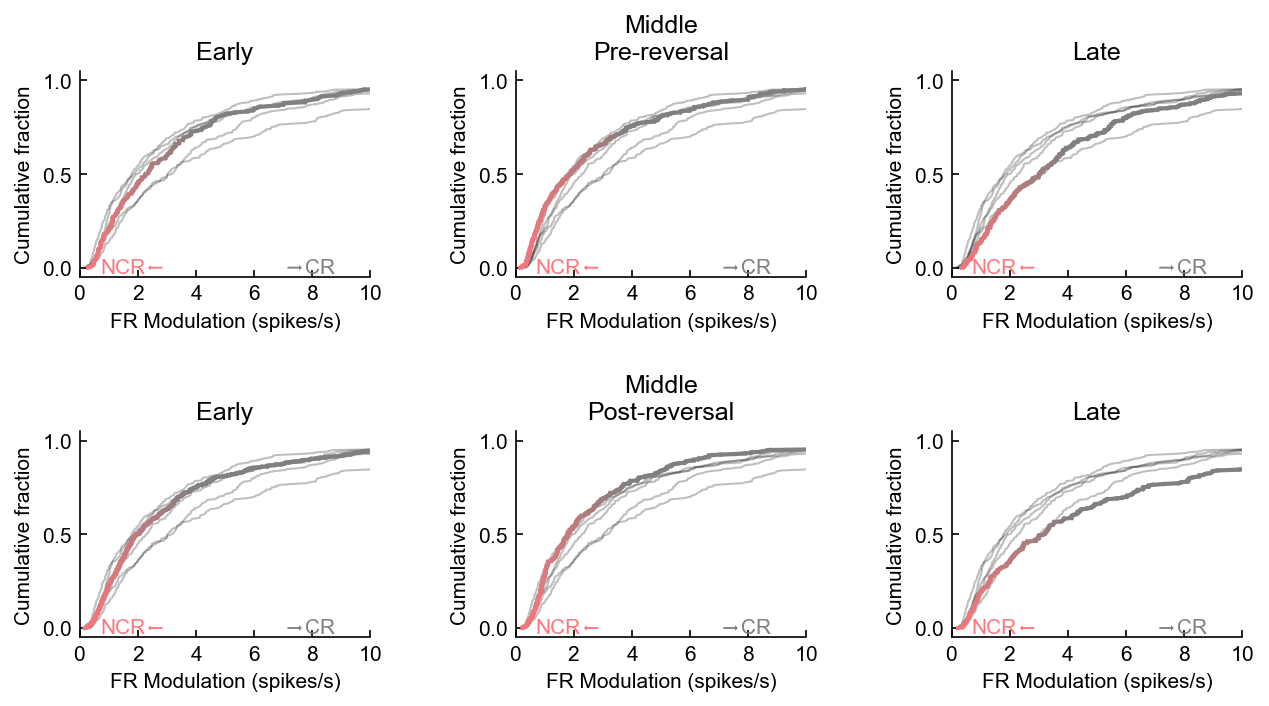

In [38]:
def add_NCR_CR_scale(ax, method='one_sided', height=0.1, hoffset=0.5, voffset=.05, fontsize=10, alength=.5, awidth=.05, aoffset=0.1):
    x_min, x_max = ax.get_xlim()    
    y_min, y_max = ax.get_ylim()
    if method == 'one_sided':
        # ax.add_patch(plt.Polygon([[x_min, y_min - height], [x_min, y_min], [x_max, y_min - height]], lw=0, facecolor=NNR_COLOR))
        # ax.add_patch(plt.Polygon([[x_min, y_min], [x_max, y_min], [x_max, y_min - height]], lw=0, facecolor=R_COLOR))
        ax.add_patch(plt.Arrow(x_min + hoffset + alength + aoffset, y_min - height + voffset, -alength, 0, facecolor=NCR_COLOR, lw=0, width=awidth))
        ax.add_patch(plt.Arrow(x_max - hoffset - alength - aoffset, y_min - height + voffset, alength, 0, facecolor=CR_COLOR, lw=0, width=awidth))
        ax.text(x_min + hoffset, y_min - height + voffset, "NCR", ha='right', va='center', c=NCR_COLOR, fontsize=fontsize)
        ax.text(x_max - hoffset, y_min - height + voffset, "CR", ha='left', va='center', c=CR_COLOR, fontsize=fontsize)
    elif method == 'two_sided':
        ax.add_patch(plt.Polygon([[0, y_min - height], [0, y_min], [x_max, y_min - height]], lw=0, facecolor=NCR_COLOR))
        ax.add_patch(plt.Polygon([[0, y_min - height], [0, y_min], [x_min, y_min - height]], lw=0, facecolor=NCR_COLOR))
        
        ax.add_patch(plt.Polygon([[0, y_min], [x_max, y_min], [x_max, y_min - height]], lw=0, facecolor=CR_COLOR))
        ax.add_patch(plt.Polygon([[0, y_min], [x_min, y_min], [x_min, y_min - height]], lw=0, facecolor=CR_COLOR))

        ax.text(x_min - hoffset, y_min - height - voffset, "-CR", ha='left', va='bottom', c=CR_COLOR, fontsize=fontsize)
        ax.text(x_max + hoffset, y_min - height - voffset, "+CR", ha='left', va='bottom', c=CR_COLOR, fontsize=fontsize)
        ax.text(0, y_min - height - 10*voffset, "NCR", ha='center', va='top', c=NCR_COLOR, fontsize=fontsize)
    ax.set_ylim([y_min-height, y_max])
    pass

labels = ['Early','Middle\nPre-reversal','Late','Early','Middle\nPost-reversal','Late']
statlabels = ['Early Pre-reversal','Middle Pre-reversal','Late Pre-reversal','Early Post-reversal','Middle Post-reversal','Late Post-reversal']
dataToUse = [preEarly,preMid,preLate,postEarly,postMid,postLate]
sessionsToUse = [preEarlySess,preMidSess,preLateSess,postEarlySess,postMidSess,postLateSess]
idsToUse = [preEarlyClust,preMidClust,preLateClust,postEarlyClust,postMidClust,postLateClust]

trans = 0.25

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,3,height_ratios=[1,1],hspace=0.75,wspace=0.5)
ax1 = plt.subplot(gs[0,0])#Raster
ax2 = plt.subplot(gs[0,1],sharex=ax1,sharey=ax1)
ax3 = plt.subplot(gs[0,2],sharex=ax1,sharey=ax1)
ax4 = plt.subplot(gs[1,0],sharex=ax1,sharey=ax1)
ax5 = plt.subplot(gs[1,1],sharex=ax1,sharey=ax1)
ax6 = plt.subplot(gs[1,2],sharex=ax1,sharey=ax1)
axs = [ax1,ax2,ax3,ax4,ax5,ax6]

def colored_line(ax,x,y,colormap,lw=1,alpha=1):
    for idx in range(len(x)-1):
        xs = [x[idx],x[idx+1]]
        ys = [y[idx],y[idx+1]]
        color = colormap[idx]
        ax.plot(xs,ys,lw=lw,color=color,alpha=alpha);

for idx,column in enumerate(dataToUse):
    column = column[np.logical_not(np.isnan(column))]
    column = np.sort(column)
    fraction = np.linspace(0,1,num=len(column))
    
    for idx2,column2 in enumerate(dataToUse):
        if idx2 != idx:
            column2 = column2[np.logical_not(np.isnan(column2))]
            column2 = np.sort(column2)
            fraction2 = np.linspace(0,1,num=len(column2))
            colormap=NCR_CR_cmap(column2/4)
            axs[idx].plot(column2,fraction2,color='k',lw=1,alpha=trans)
    
    colormap=NCR_CR_cmap(column/4)
    #axs[idx].plot(column,fraction,color=colormap,lw=2)
    colored_line(axs[idx],column,fraction,colormap,lw=2)
    axs[idx].set_xticks([0,2,4,6,8,10])
    axs[idx].set_xlim([0,10])
    axs[idx].set_title(labels[idx])
    axs[idx].set_xlabel('FR Modulation (spikes/s)')
    axs[idx].set_ylabel('Cumulative fraction')
    
    add_NCR_CR_scale(axs[idx], method='one_sided', height=0, hoffset=2.25)
    
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' Cumulative distributions.pdf'),transparent=False,facecolor="white")

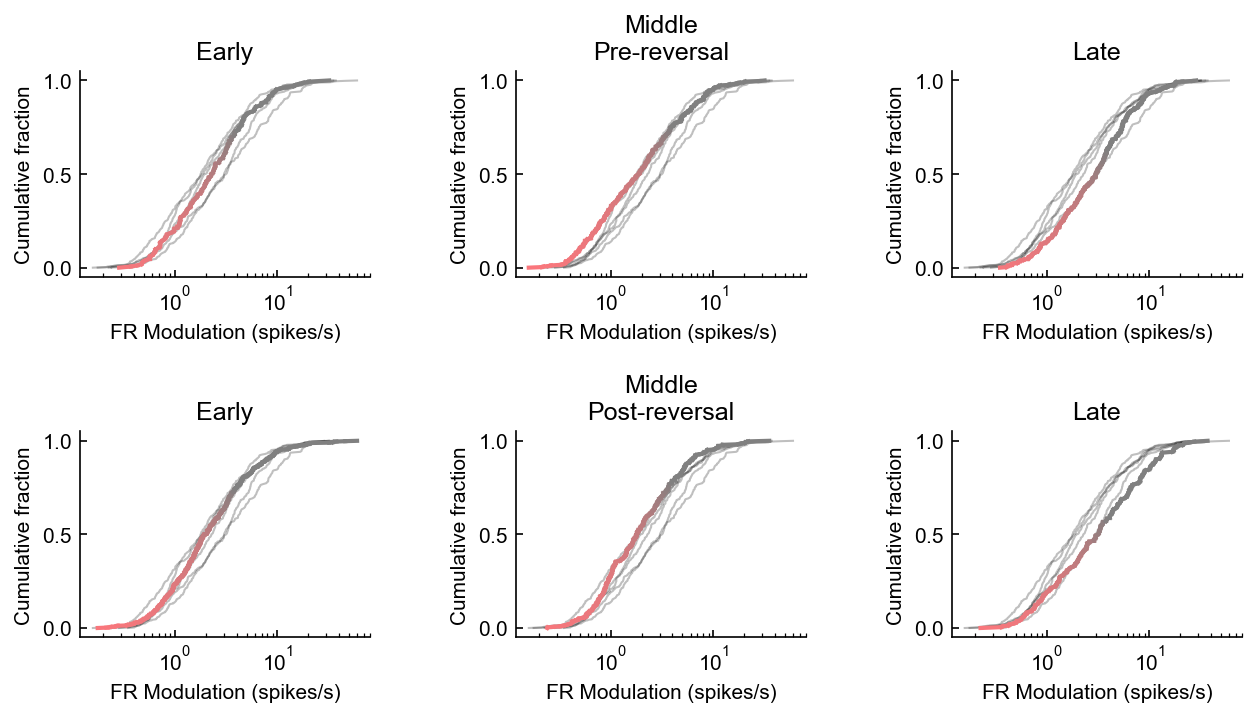

In [39]:
def add_NCR_CR_scale(ax, method='one_sided', height=0.1, hoffset=0.5, voffset=.05, fontsize=10, alength=.5, awidth=.05, aoffset=0.1):
    x_min, x_max = ax.get_xlim()    
    y_min, y_max = ax.get_ylim()
    if method == 'one_sided':
        # ax.add_patch(plt.Polygon([[x_min, y_min - height], [x_min, y_min], [x_max, y_min - height]], lw=0, facecolor=NNR_COLOR))
        # ax.add_patch(plt.Polygon([[x_min, y_min], [x_max, y_min], [x_max, y_min - height]], lw=0, facecolor=R_COLOR))
        ax.add_patch(plt.Arrow(x_min + hoffset + alength + aoffset, y_min - height + voffset, -alength, 0, facecolor=NCR_COLOR, lw=0, width=awidth))
        ax.add_patch(plt.Arrow(x_max - hoffset - alength - aoffset, y_min - height + voffset, alength, 0, facecolor=CR_COLOR, lw=0, width=awidth))
        ax.text(x_min + hoffset, y_min - height + voffset, "NCR", ha='right', va='center', c=NCR_COLOR, fontsize=fontsize)
        ax.text(x_max - hoffset, y_min - height + voffset, "CR", ha='left', va='center', c=CR_COLOR, fontsize=fontsize)
    elif method == 'two_sided':
        ax.add_patch(plt.Polygon([[0, y_min - height], [0, y_min], [x_max, y_min - height]], lw=0, facecolor=NCR_COLOR))
        ax.add_patch(plt.Polygon([[0, y_min - height], [0, y_min], [x_min, y_min - height]], lw=0, facecolor=NCR_COLOR))
        
        ax.add_patch(plt.Polygon([[0, y_min], [x_max, y_min], [x_max, y_min - height]], lw=0, facecolor=CR_COLOR))
        ax.add_patch(plt.Polygon([[0, y_min], [x_min, y_min], [x_min, y_min - height]], lw=0, facecolor=CR_COLOR))

        ax.text(x_min - hoffset, y_min - height - voffset, "-CR", ha='left', va='bottom', c=CR_COLOR, fontsize=fontsize)
        ax.text(x_max + hoffset, y_min - height - voffset, "+CR", ha='left', va='bottom', c=CR_COLOR, fontsize=fontsize)
        ax.text(0, y_min - height - 10*voffset, "NCR", ha='center', va='top', c=NCR_COLOR, fontsize=fontsize)
    ax.set_ylim([y_min-height, y_max])
    pass

labels = ['Early','Middle\nPre-reversal','Late','Early','Middle\nPost-reversal','Late']
statlabels = ['Early Pre-reversal','Middle Pre-reversal','Late Pre-reversal','Early Post-reversal','Middle Post-reversal','Late Post-reversal']
dataToUse = [preEarly,preMid,preLate,postEarly,postMid,postLate]
sessionsToUse = [preEarlySess,preMidSess,preLateSess,postEarlySess,postMidSess,postLateSess]
idsToUse = [preEarlyClust,preMidClust,preLateClust,postEarlyClust,postMidClust,postLateClust]

trans = 0.25

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,3,height_ratios=[1,1],hspace=0.75,wspace=0.5)
ax1 = plt.subplot(gs[0,0])#Raster
ax2 = plt.subplot(gs[0,1],sharex=ax1,sharey=ax1)
ax3 = plt.subplot(gs[0,2],sharex=ax1,sharey=ax1)
ax4 = plt.subplot(gs[1,0],sharex=ax1,sharey=ax1)
ax5 = plt.subplot(gs[1,1],sharex=ax1,sharey=ax1)
ax6 = plt.subplot(gs[1,2],sharex=ax1,sharey=ax1)
axs = [ax1,ax2,ax3,ax4,ax5,ax6]

def colored_line(ax,x,y,colormap,lw=1,alpha=1):
    for idx in range(len(x)-1):
        xs = [x[idx],x[idx+1]]
        ys = [y[idx],y[idx+1]]
        color = colormap[idx]
        ax.plot(xs,ys,lw=lw,color=color,alpha=alpha);

for idx,column in enumerate(dataToUse):
    column = column[np.logical_not(np.isnan(column))]
    column = np.sort(column)
    fraction = np.linspace(0,1,num=len(column))
    
    for idx2,column2 in enumerate(dataToUse):
        if idx2 != idx:
            column2 = column2[np.logical_not(np.isnan(column2))]
            column2 = np.sort(column2)
            fraction2 = np.linspace(0,1,num=len(column2))
            colormap=NCR_CR_cmap(column2/4)
            axs[idx].plot(column2,fraction2,color='k',lw=1,alpha=trans)
    
    colormap=NCR_CR_cmap(column/4)
    #axs[idx].plot(column,fraction,color=colormap,lw=2)
    colored_line(axs[idx],column,fraction,colormap,lw=2)
    #axs[idx].set_xticks([0,2,4,6,8,10])
    #axs[idx].set_xlim([0,10])
    axs[idx].set_xscale('log',base=10)
    axs[idx].set_title(labels[idx])
    axs[idx].set_xlabel('FR Modulation (spikes/s)')
    axs[idx].set_ylabel('Cumulative fraction')
    
    #add_NCR_CR_scale(axs[idx], method='one_sided', height=0, hoffset=2.25)
    
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' Log cumulative distributions.pdf'),transparent=False,facecolor="white")

In [28]:
AC = []
M2 = []
ACClust = []
M2Clust = []
ACSess = []
M2Sess = []

for session in sessions:
    sessionfile = ilep.loadSessionCached(directory,session)
    
    if sessionfile.meta.animal in ['BS_33','BS_67','BS_73','BS_78']:
        continue
    
    clusters_to_append = []
    ids_to_append = []
    sessions_to_append = []
    for clust in sessionfile.clusters.good:
        clusters_to_append.append( sessionfile.responsiveness[clust]['all_trials'].FRmodulation )
        ids_to_append.append( clust )
        sessions_to_append.append( session )
    
    if sessionfile.meta.region == 'AC':
        AC = np.concatenate((AC,clusters_to_append))
        ACClust = np.concatenate((ACClust,ids_to_append))
        ACSess = np.concatenate((ACSess,sessions_to_append))
    elif sessionfile.meta.region == 'M2':
        M2 = np.concatenate((M2,clusters_to_append))
        M2Clust = np.concatenate((M2Clust,ids_to_append))
        M2Sess = np.concatenate((M2Sess,sessions_to_append))
            
print('AC: '+str(len(AC))+' cells')
print('M2: '+str(len(M2))+' cells')

AC: 1846 cells
M2: 2242 cells


Significances
**** AC - M2 : 2.7408500462878776e-21
**** M2 - AC : 2.7408500462878776e-21
AC
Min    :BS_83_9_AC.pickle 26.0
Median :BS_40_16_AC.pickle 0.0
Max    :BS_42_3_AC.pickle 12.0
M2
Min    :BS_40_5_M2.pickle 78.0
Median :BS_72_7_M2.pickle 30.0
Max    :BS_42_2_M2.pickle 62.0


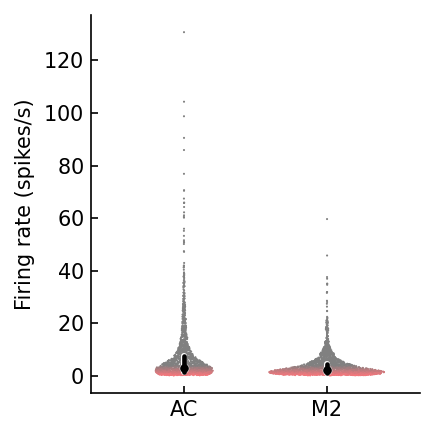

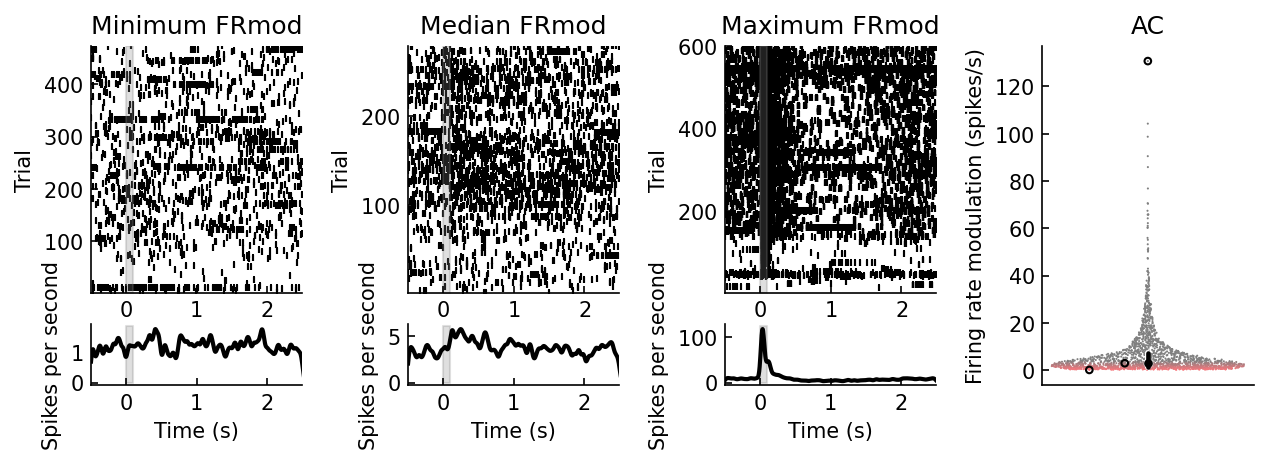

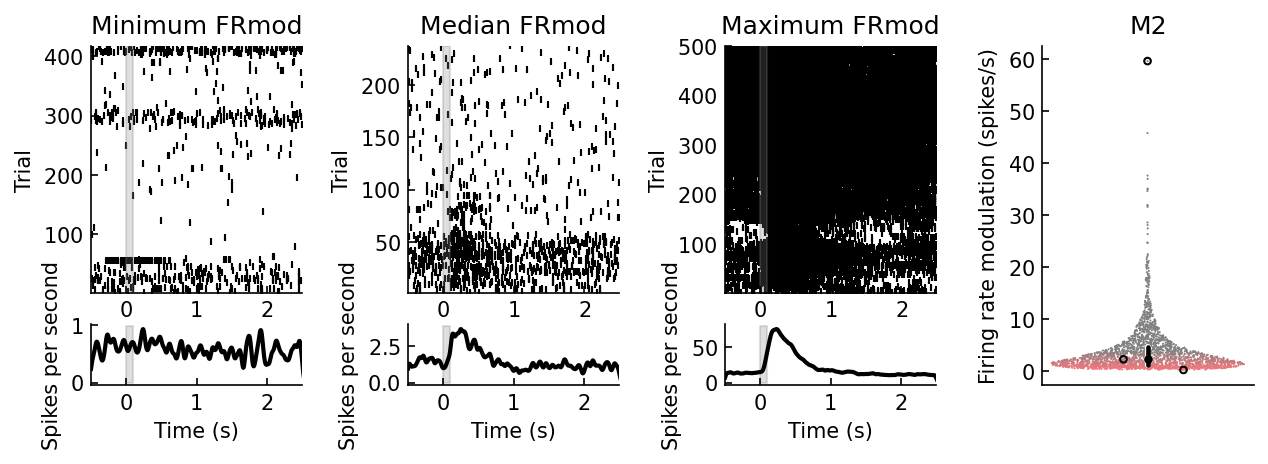

In [93]:
labels = ['AC','M2']
dataToUse = [AC,M2]
sessionsToUse = [ACSess,M2Sess]
idsToUse = [ACClust,M2Clust]

bandwidth = 'scott'
total=1.0
width = 4
size=1
#color='k'
highlights = []
scale_factor = 1.0
trans = 1

fig, ax = plt.subplots(figsize=(3,3))
for idx,column in enumerate(dataToUse):
    column = column[np.logical_not(np.isnan(column))]
    f_density = gaussian_kde(column, bw_method=bandwidth)
    X_plot = scale_factor * f_density(column) * (np.random.rand(len(column)) -.5) * width + idx
    
    color=NCR_CR_cmap(column/4)
    
    ax.scatter(X_plot, column, s=size, c=color, zorder=0, alpha=trans, lw=0)
    
    #Highlight units
    if len(highlights) > 0:
        ax.scatter(X_plot[highlights], column[highlights], s=size*2, color='k', marker=highlight_marker, facecolors='none')
        
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xticks(range(2))
ax.set_xticklabels(labels)
ax.set_xlim([-0.65,1.65])
        
print('Significances')
MCfactor = 1 # Multiple comparisons factor
for idx,column in enumerate(dataToUse):
    for idxx,column2 in enumerate(dataToUse):
        if idx!=idxx:
            column = column[~np.isnan(column)]
            column2 = column2[~np.isnan(column2)]
            pval = mannwhitneyu(column,column2).pvalue
            if pval <=0.0001 / MCfactor:
                print('**** ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.001 / MCfactor:
                print('***  ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.01 / MCfactor:
                print('**   ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.05 / MCfactor:
                print('*    ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            else:
                print('     ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
    
plt.tight_layout()
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries','Responsiveness Between Regions.pdf'),transparent=False,facecolor="white")





for idx,column in enumerate(dataToUse):
    
    fig = plt.figure(figsize=(10,3))
    gs = fig.add_gridspec(2,4,height_ratios=[4,1],hspace=0.2,wspace=0.5)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax3 = plt.subplot(gs[0,1])#Raster
    ax4 = plt.subplot(gs[1,1],sharex=ax1)#PSTH
    ax5 = plt.subplot(gs[0,2])#Raster
    ax6 = plt.subplot(gs[1,2],sharex=ax1)#PSTH
    ax7 = plt.subplot(gs[:,3])
    
    sesss = sessionsToUse[idx]
    ids = idsToUse[idx]
    sesss = sesss[np.logical_not(np.isnan(column))]
    ids = ids[np.logical_not(np.isnan(column))]
    column = column[np.logical_not(np.isnan(column))]
    idxmin = np.where(column == np.min(column))[0][0]
    #Calculating the median requires some extra work because median's behavior is different for even length arrays
    temp = np.sort(column)
    temp = temp[int(len(temp)/2)]
    idxmedian = np.where(column == temp)[0][0]
    idxmax = np.where(column == np.max(column))[0][0]
    
    highlights = [idxmin,idxmedian,idxmax]    
    plotUnitGivenAx(ax1,ax2,ilep.loadSessionCached(directory,sesss[idxmin]),ids[idxmin])
    plotUnitGivenAx(ax3,ax4,ilep.loadSessionCached(directory,sesss[idxmedian]),ids[idxmedian])
    plotUnitGivenAx(ax5,ax6,ilep.loadSessionCached(directory,sesss[idxmax]),ids[idxmax])

    f_density = gaussian_kde(column, bw_method=bandwidth)
    X_plot = scale_factor * f_density(column) * (np.random.rand(len(column)) -.5) * width + 0
    
    color=NCR_CR_cmap(column/4)
    
    ax7.scatter(X_plot, column, s=size, c=color, zorder=0, alpha=trans, lw=0)
    if len(highlights) > 0:
        ax7.scatter(X_plot[highlights], column[highlights], s=size*10, color='k', marker='o', facecolors='none')
    ax7.set_xticks([])
        
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax7.scatter([0], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax7.scatter([0], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax7.plot([0, 0], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax7.plot([0, 0], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')
        
    ax7.set_ylabel('Firing rate modulation (spikes/s)')
    ax1.set_title('Minimum FRmod')
    ax3.set_title('Median FRmod')
    ax5.set_title('Maximum FRmod')
    ax7.set_title(labels[idx])
    
    
    
    print(labels[idx])
    print('Min    :'+sesss[idxmin]+' '+str(ids[idxmin]))
    print('Median :'+sesss[idxmedian]+' '+str(ids[idxmedian]))
    print('Max    :'+sesss[idxmax]+' '+str(ids[idxmax]))
    
    plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',labels[idx] + ' responsiveness.pdf'),transparent=False,facecolor="white")

Significances
**** AC - M2 : 2.7408500462878776e-21
**** M2 - AC : 2.7408500462878776e-21
AC
Min    :BS_83_9_AC.pickle 26.0
Median :BS_40_16_AC.pickle 0.0
Max    :BS_42_3_AC.pickle 12.0
M2
Min    :BS_40_5_M2.pickle 78.0
Median :BS_72_7_M2.pickle 30.0
Max    :BS_42_2_M2.pickle 62.0


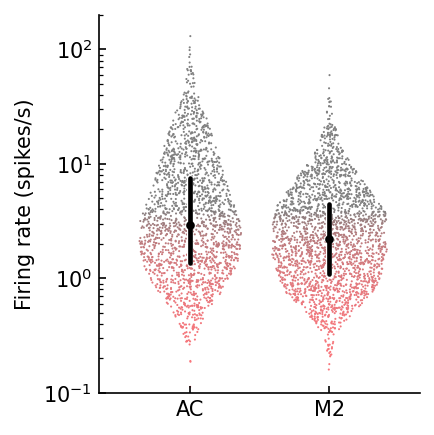

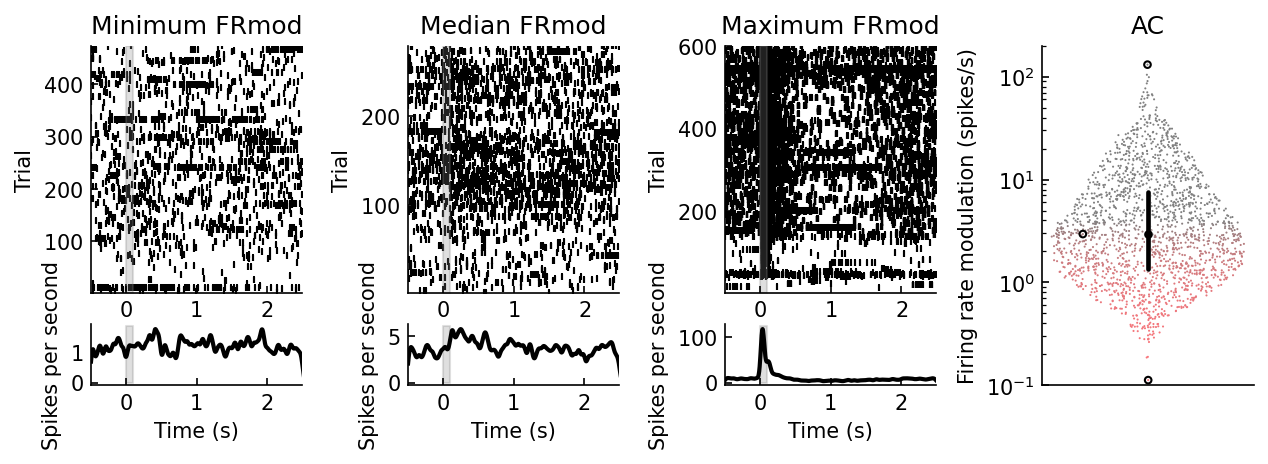

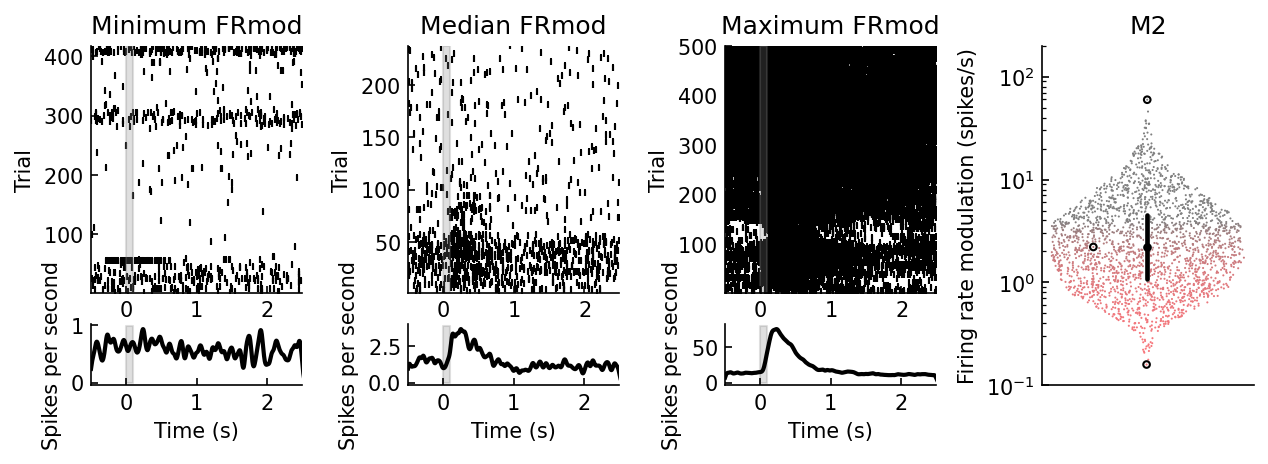

In [94]:
labels = ['AC','M2']
dataToUse = [AC,M2]
sessionsToUse = [ACSess,M2Sess]
idsToUse = [ACClust,M2Clust]

bandwidth = 'scott'
total=1.0
width = 1
size=1
#color='k'
highlights = []
scale_factor = 1.0
trans = 1

fig, ax = plt.subplots(figsize=(3,3))
for idx,column in enumerate(dataToUse):
    colorcolumn = column
    #column = np.log(column)
    
    column = column[np.logical_not(np.isnan(column))]
    f_density = gaussian_kde(np.log10(column), bw_method=bandwidth)
    X_plot = scale_factor * f_density(np.log10(column)) * (np.random.rand(len(column)) -.5) * width + idx
    
    color=NCR_CR_cmap(colorcolumn/4)
    
    ax.scatter(X_plot, column, s=size, c=color, zorder=0, alpha=trans, lw=0)
    
    #Highlight units
    if len(highlights) > 0:
        ax.scatter(X_plot[highlights], column[highlights], s=size*2, color='k', marker=highlight_marker, facecolors='none')
        
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')

ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xticks(range(2))
ax.set_xticklabels(labels)
ax.set_xlim([-0.65,1.65])
ax.set_yscale('log',base=10)
ax.set_ylim([0.1,200])
        
print('Significances')
MCfactor = 1 # Multiple comparisons factor
for idx,column in enumerate(dataToUse):
    for idxx,column2 in enumerate(dataToUse):
        if idx!=idxx:
            column = column[~np.isnan(column)]
            column2 = column2[~np.isnan(column2)]
            pval = mannwhitneyu(column,column2).pvalue
            if pval <=0.0001 / MCfactor:
                print('**** ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.001 / MCfactor:
                print('***  ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.01 / MCfactor:
                print('**   ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.05 / MCfactor:
                print('*    ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            else:
                print('     ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
    
plt.tight_layout()
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries','Log responsiveness Between Regions.pdf'),transparent=False,facecolor="white")





for idx,column in enumerate(dataToUse):
    colorcolumn = column
    #column = np.log(column)
    
    fig = plt.figure(figsize=(10,3))
    gs = fig.add_gridspec(2,4,height_ratios=[4,1],hspace=0.2,wspace=0.5)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax3 = plt.subplot(gs[0,1])#Raster
    ax4 = plt.subplot(gs[1,1],sharex=ax1)#PSTH
    ax5 = plt.subplot(gs[0,2])#Raster
    ax6 = plt.subplot(gs[1,2],sharex=ax1)#PSTH
    ax7 = plt.subplot(gs[:,3])
    
    sesss = sessionsToUse[idx]
    ids = idsToUse[idx]
    sesss = sesss[np.logical_not(np.isnan(column))]
    ids = ids[np.logical_not(np.isnan(column))]
    column = column[np.logical_not(np.isnan(column))]
    idxmin = np.where(column == np.min(column))[0][0]
    #Calculating the median requires some extra work because median's behavior is different for even length arrays
    temp = np.sort(column)
    temp = temp[int(len(temp)/2)]
    idxmedian = np.where(column == temp)[0][0]
    idxmax = np.where(column == np.max(column))[0][0]
    
    highlights = [idxmin,idxmedian,idxmax]    
    plotUnitGivenAx(ax1,ax2,ilep.loadSessionCached(directory,sesss[idxmin]),ids[idxmin])
    plotUnitGivenAx(ax3,ax4,ilep.loadSessionCached(directory,sesss[idxmedian]),ids[idxmedian])
    plotUnitGivenAx(ax5,ax6,ilep.loadSessionCached(directory,sesss[idxmax]),ids[idxmax])

    f_density = gaussian_kde(np.log10(column), bw_method=bandwidth)
    X_plot = scale_factor * f_density(np.log10(column)) * (np.random.rand(len(column)) -.5) * width + 0
    
    color=NCR_CR_cmap(colorcolumn/4)
    
    ax7.scatter(X_plot, column, s=size, c=color, zorder=0, alpha=trans, lw=0)
    if len(highlights) > 0:
        ax7.scatter(X_plot[highlights], column[highlights], s=size*10, color='k', marker='o', facecolors='none')
    ax7.set_xticks([])
    ax7.set_yscale('log',base=10)
    ax7.set_ylim([0.1,200])
    
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax7.scatter([0], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax7.scatter([0], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax7.plot([0, 0], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax7.plot([0, 0], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')
        
    ax7.set_ylabel('Firing rate modulation (spikes/s)')
    ax1.set_title('Minimum FRmod')
    ax3.set_title('Median FRmod')
    ax5.set_title('Maximum FRmod')
    ax7.set_title(labels[idx])
    
    
    
    print(labels[idx])
    print('Min    :'+sesss[idxmin]+' '+str(ids[idxmin]))
    print('Median :'+sesss[idxmedian]+' '+str(ids[idxmedian]))
    print('Max    :'+sesss[idxmax]+' '+str(ids[idxmax]))
    
    plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',labels[idx] + ' log responsiveness.pdf'),transparent=False,facecolor="white")

# Pre-post switch

<ipython-input-40-0b55228c60d6>:20: RuntimeWarning: divide by zero encountered in log10
  f_density = gaussian_kde(np.log10(KDEcolumn), bw_method=bandwidth)
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\lib\function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


ValueError: array must not contain infs or NaNs

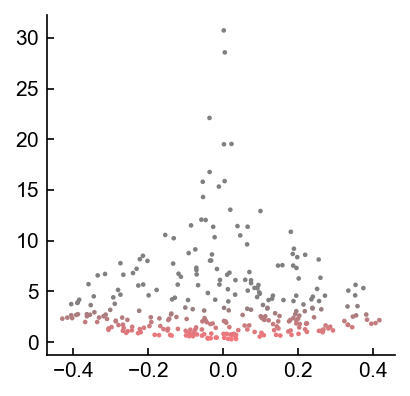

In [40]:
labels = ['Pre-switch','Post-Switch']
dataToUse = [switchPre,switchPost]
Xs = []
Ys = []

bandwidth = 'scott'
total=1.0
width = 1
size=5
#color='k'
highlights = []
scale_factor = 1.0
trans = 1

fig, ax = plt.subplots(figsize=(3,3))
for idx,column in enumerate(dataToUse):
    KDEcolumn = column[np.isfinite(column)]
    colorcolumn = column
    
    f_density = gaussian_kde(np.log10(KDEcolumn), bw_method=bandwidth)
    X_plot = scale_factor * f_density(np.log10(column)) * (np.random.rand(len(column)) -.5) * width + idx
    Xs.append(X_plot)
    Ys.append(column)
    
    color=NCR_CR_cmap(colorcolumn/4)
    
    ax.scatter(X_plot, column, s=size, c=color, zorder=0, alpha=trans, lw=0)
        
    #Plot summary
    summary_color='k'
    summary_size=20
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*.5, zorder=1)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*.5, zorder=2)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=1, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=2, solid_capstyle='round')

for idx in range(len(Xs[0])):
    ax.plot( [Xs[0][idx],Xs[1][idx]] , [Ys[0][idx],Ys[1][idx]] ,color='grey',lw=0.1,zorder=-10)
    
ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xticks(range(2))
ax.set_xticklabels(labels)
ax.set_xlim([-0.65,1.65])
ax.set_yscale('log',base=10)
ax.set_ylim([0.1,200])
        
print('Significances')
MCfactor = 1 # Multiple comparisons factor
for idx,column in enumerate(dataToUse):
    for idxx,column2 in enumerate(dataToUse):
        if idx!=idxx:
            column = column[~np.isnan(column)]
            column2 = column2[~np.isnan(column2)]
            pval = mannwhitneyu(column,column2).pvalue
            if pval <=0.0001 / MCfactor:
                print('**** ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.001 / MCfactor:
                print('***  ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.01 / MCfactor:
                print('**   ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.05 / MCfactor:
                print('*    ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            else:
                print('     ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
    
#plt.tight_layout()
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' log responsiveness during reversal.pdf'),transparent=False,facecolor="white")

Significances
     Pre-switch - Post-Switch : 0.34895093359660634
     Post-Switch - Pre-switch : 0.34895093359660634


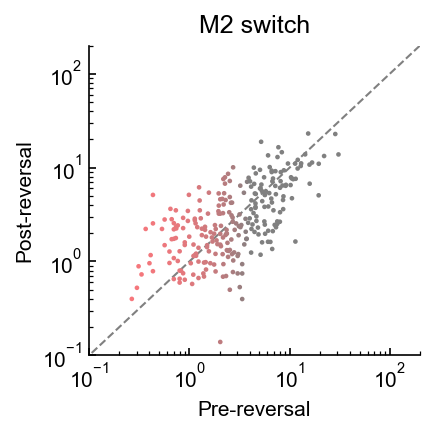

In [44]:
labels = ['Pre-switch','Post-Switch']
dataToUse = [switchPre,switchPost]
Xs = []
Ys = []

bandwidth = 'scott'
total=1.0
width = 1
size=5
#color='k'
highlights = []
scale_factor = 1.0
trans = 1

fig, ax = plt.subplots(figsize=(3,3))

colorcolumn = (dataToUse[0]+dataToUse[0])/2
color=NCR_CR_cmap(colorcolumn/4)
    
ax.scatter(dataToUse[0],dataToUse[1], s=size, c=color, zorder=0, alpha=trans, lw=0)    
ax.set_xlabel('Pre-reversal')
ax.set_ylabel('Post-reversal')

ax.plot([0,300],[0,300],color='grey',linestyle='--',lw=1,zorder=-10)
    
ax.set_xscale('log',base=10)
ax.set_xlim([0.1,200])
ax.set_yscale('log',base=10)
ax.set_ylim([0.1,200])
        
print('Significances')
MCfactor = 1 # Multiple comparisons factor
for idx,column in enumerate(dataToUse):
    for idxx,column2 in enumerate(dataToUse):
        if idx!=idxx:
            column = column[~np.isnan(column)]
            column2 = column2[~np.isnan(column2)]
            pval = mannwhitneyu(column,column2).pvalue
            if pval <=0.0001 / MCfactor:
                print('**** ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.001 / MCfactor:
                print('***  ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.01 / MCfactor:
                print('**   ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            elif pval <=0.05 / MCfactor:
                print('*    ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
            else:
                print('     ' + labels[idx] + ' - ' + labels[idxx] + ' : ' + str(pval))
    
ax.set_title(reg+' switch')
plt.tight_layout()
plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries',reg+' Log responsiveness during reversal.pdf'),transparent=False,facecolor="white")

# Responsiveness over depth

BS_72_4_M2.pickle cluster 57: -36.5um
BS_83_6_M2.pickle cluster 39: -17.0um
BS_83_9_M2.pickle cluster 65: -156.5um
BS_85_7_M2.pickle cluster 63: -81.0um
BS_85_7_M2.pickle cluster 69: -56.0um
BS_85_7_M2.pickle cluster 172: -6.0um
BS_85_8_AC.pickle cluster 44: -18.5um


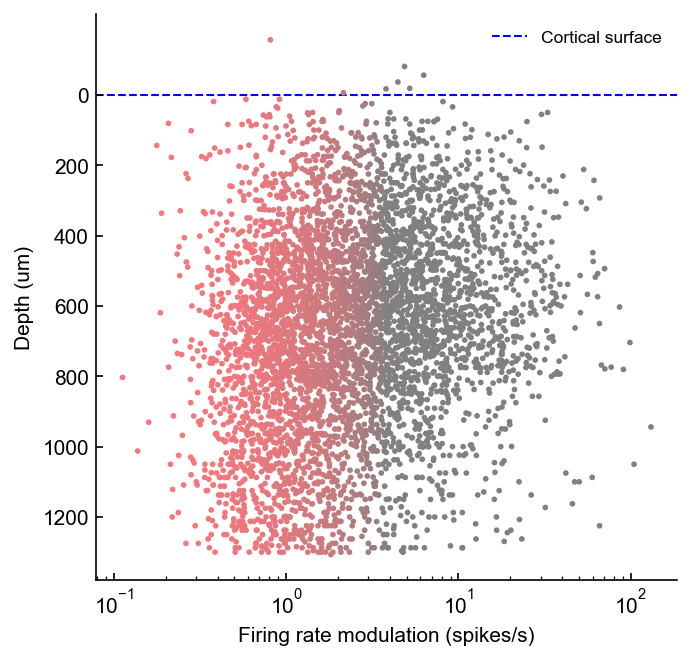

In [41]:
depth = []
FRmod = []
for session in sessions:
    sessionfile = ilep.loadSessionCached(directory,session)
    for clust in sessionfile.clusters.good:
        
        thisdepth = sessionfile.clusters.depth[clust]
        if thisdepth < 0:
            print(session + ' cluster ' + str(clust) + ': ' + str(thisdepth) + 'um')
        
        depth.append(sessionfile.clusters.depth[clust])
        FRmod.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
depth = np.array(depth)
FRmod = np.array(FRmod)
        
fig, ax = plt.subplots(figsize=(5,5))

color=NCR_CR_cmap(FRmod/4)
ax.scatter(FRmod,depth,s=3,c=color)
ax.set_xscale('log')

ylims = ax.get_ylim()
ax.set_ylim([ylims[1],ylims[0]])

xlims = ax.get_xlim()
ax.plot(xlims,[0,0],color='blue',linestyle='--',zorder=-10,lw=1,label='Cortical surface')
ax.set_xlim(xlims)

ax.set_yticks([0,200,400,600,800,1000,1200])
ax.set_yticklabels([0,200,400,600,800,1000,1200])

ax.set_ylabel('Depth (um)')
ax.set_xlabel('Firing rate modulation (spikes/s)')
ax.legend(frameon=False,loc='upper right')
plt.savefig(os.path.join('D:\\\\TempFigures','Responsiveness by depth.png'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\TempFigures','Responsiveness by depth.pdf'),transparent=False,facecolor="white")
pass

# Spike count correlations across regions

In [5]:
def get_paired_sessionfile(sessionfile,directory,sessions):
    if sessionfile.meta.region == 'AC':
        target_region = 'M2'
    elif sessionfile.meta.region == 'M2':
        target_region = 'AC'
        
    animal = sessionfile.meta.animal
    day_of_training = sessionfile.meta.day_of_training
    date = sessionfile.meta.date
    
    target_sessionfile = None
    for session in sessions:
        other_sessionfile = ilep.loadSessionCached(directory,session)

        if other_sessionfile.meta.region != target_region:
            continue
        
        if other_sessionfile.meta.files != sessionfile.meta.files:
            continue
        
        #if other_sessionfile.meta.animal != animal:
        #    continue
        
        #if other_sessionfile.meta.day_of_training != day_of_training:
        #    continue
        
        #if other_sessionfile.meta.date != date:
        #    continue
            
        if not (target_sessionfile is None):
            print('ERROR: Multiple paired sessionfiles for ' + ilep.generateDateString(sessionfile) + ' ==> ' + ilep.generateDateString(target_sessionfile) + ' already selected')
            print('AC    : '+str(sessionfile_AC.meta.files))
            print('M2-old: '+str(target_sessionfile.meta.files))
            print('M2-new: '+str(other_sessionfile.meta.files))
            raise Exception
            
        target_sessionfile = other_sessionfile
        
    return target_sessionfile

def get_all_paired_sessionfiles(directory,sessions):
    sessionpairs = []
    
    for session in tqdm(sessions):
        sessionfile_AC = ilep.loadSessionCached(directory,session)
        
        if sessionfile_AC.meta.region != 'AC':
            continue

        sessionfile_M2 = get_paired_sessionfile(sessionfile_AC,directory,sessions)
        if sessionfile_M2 is None:
            print(ilep.generateDateString(sessionfile_AC) + ': no paired recording found')
            continue
        
        sessionpairs.append( (sessionfile_AC,sessionfile_M2) )
        
    return sessionpairs

#get_all_paired_sessionfiles(directory,sessions)
all_session_pairs = get_all_paired_sessionfiles(directory,sessions)

 22%|██▏       | 75/344 [00:26<01:38,  2.73it/s]

BS_40_18_AC_9-2-2021: no paired recording found


 22%|██▏       | 76/344 [00:26<01:55,  2.32it/s]

BS_40_19_AC_9-8-2021: no paired recording found


 22%|██▏       | 77/344 [00:27<02:11,  2.03it/s]

BS_40_21_AC_9-10-2021: no paired recording found


 23%|██▎       | 78/344 [00:28<02:25,  1.82it/s]

BS_40_22_AC_9-13-2021: no paired recording found


 24%|██▍       | 83/344 [00:30<01:59,  2.19it/s]

BS_40_4_AC_8-9-2021: no paired recording found


 26%|██▌       | 90/344 [00:33<01:42,  2.47it/s]

BS_40_8_AC_8-13-2021: no paired recording found


 31%|███▏      | 108/344 [00:40<01:26,  2.73it/s]

BS_41_8_AC_8-17-2021: no paired recording found


 39%|███▊      | 133/344 [00:49<01:16,  2.75it/s]

BS_49_10_AC_9-15-2021: no paired recording found


 39%|███▉      | 134/344 [00:50<01:29,  2.35it/s]

BS_49_12_AC_9-17-2021: no paired recording found


 41%|████      | 141/344 [00:53<01:20,  2.52it/s]

BS_49_16_AC_9-23-2021: no paired recording found


 44%|████▍     | 152/344 [00:57<01:12,  2.65it/s]

BS_49_7_AC_9-10-2021: no paired recording found


 45%|████▍     | 154/344 [00:58<01:10,  2.69it/s]

BS_49_9_AC_9-13-2021: no paired recording found


 46%|████▌     | 157/344 [00:59<01:17,  2.42it/s]

BS_50_11_AC_9-23-2021: no paired recording found


 51%|█████     | 176/344 [01:05<00:50,  3.32it/s]

BS_56_1_AC_10-21-2021: no paired recording found


 53%|█████▎    | 183/344 [01:08<00:58,  2.76it/s]

BS_56_7_AC_10-29-2021: no paired recording found


 86%|████████▌ | 295/344 [01:47<00:17,  2.74it/s]

BS_85_13_AC_2-8-2022: no paired recording found


 92%|█████████▏| 315/344 [01:55<00:10,  2.82it/s]

BS_87_10_AC_2-8-2022: no paired recording found


 92%|█████████▏| 316/344 [01:55<00:11,  2.39it/s]

BS_87_11_AC_2-9-2022: no paired recording found


100%|██████████| 344/344 [02:05<00:00,  2.74it/s]


In [20]:
#AC_responsiveness = []
#M2_responsiveness = []
#AC_FR = []
#M2_FR = []
#AC_str = []
#M2_str = []
#pearson_correlations = []

binsize = 20 #ms
number_of_bins = int(2500 / binsize)
binsize_samples = binsize * 30000 / 1000

def getPairedCorrelations(all_session_pairs,binsize)

    #First get AC and M2 cutoffs
    AC_median = []
    M2_median = []
    for session in sessions:
        sessionfile = ilep.loadSessionCached(directory,session)

        #Exclude certain animals
        if sessionfile.meta.animal in ['BS_33','BS_67','BS_73','BS_78']:
            continue

        #Only use late prereversal
        if sessionfile.meta.condition != 'prereversal expert':
            continue

        if sessionfile.meta.region == 'AC':
            AC_median = np.concatenate((AC_median,    [sessionfile.responsiveness[clust]['all_trials'].FRmodulation for clust in sessionfile.clusters.good]    ))
        if sessionfile.meta.region == 'M2':
            M2_median = np.concatenate((M2_median,    [sessionfile.responsiveness[clust]['all_trials'].FRmodulation for clust in sessionfile.clusters.good]    ))

    AC_median = np.median(AC_median)
    M2_median = np.median(M2_median)

    results = dict()
    for r in ['NCR','CR','AC_NCR_to_all','AC_CR_to_all']:
        results[r] = dict()
        for cond in ['late pre-reversal','early post-reversal','intermediate post-reversal','late post-reversal']:
            results[r][cond] = []
    print(results)

    for sessionfile_AC,sessionfile_M2 in tqdm(all_session_pairs):
        #Exclude certain animals
        if sessionfile_AC.meta.animal in ['BS_33','BS_67','BS_73','BS_78']:
            continue

        condition = 'NA'
        if sessionfile_AC.meta.condition == 'prereversal expert':
            condition = 'late pre-reversal'
        elif sessionfile_AC.meta.condition == 'postreversal naive' and sessionfile_AC.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            condition = 'early post-reversal'
        elif sessionfile_AC.meta.condition == 'postreversal naive' and sessionfile_AC.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            condition = 'intermediate post-reversal'
        elif sessionfile_AC.meta.condition == 'postreversal expert':
            condition = 'late post-reversal'

        if condition == 'NA':
            continue

        AC_neurons = sessionfile_AC.clusters.good
        M2_neurons = sessionfile_M2.clusters.good
        for AC_neuron,M2_neuron in product(AC_neurons,M2_neurons):

            AC_trials = np.array(sessionfile_AC.trim[AC_neuron].trimmed_trials)
            M2_trials = np.array(sessionfile_M2.trim[M2_neuron].trimmed_trials)
            paired_trials = AC_trials[np.isin(AC_trials,M2_trials)]

            AC_spike_counts = []
            M2_spike_counts = []
            AC_spikes = ilep.getSpikeTimes(sessionfile_AC,clust=AC_neuron)
            M2_spikes = ilep.getSpikeTimes(sessionfile_M2,clust=M2_neuron)
            for trial in paired_trials:
                for idx in range(number_of_bins):
                    starttime_samples = sessionfile_AC.trials.starts[trial]
                    starttime_samples += idx*binsize_samples
                    endtime_samples = starttime_samples + binsize_samples

                    if endtime_samples > sessionfile_AC.trials.response[trial]:
                        #We need to skip trails where the animal licks before the end of the trial block
                        #Note that because x<nan and x>nan both evaluate to False we don't actually have
                        #To check whether there is a response first before running this code
                        #Also note that AC and M2 response are the same so no need to check both
                        continue

                    AC_spike_count = len(ilep.getSpikeTimes(sessionfile_AC,starttime=starttime_samples,endtime=endtime_samples,cachedtimes=AC_spikes))
                    M2_spike_count = len(ilep.getSpikeTimes(sessionfile_M2,starttime=starttime_samples,endtime=endtime_samples,cachedtimes=M2_spikes))
                    AC_spike_counts.append(AC_spike_count)
                    M2_spike_counts.append(M2_spike_count)

                #AC_spike_count = len(ilep.getTrialSpikes(sessionfile_AC,trial,cachedtimes=AC_spikes))
                #M2_spike_count = len(ilep.getTrialSpikes(sessionfile_M2,trial,cachedtimes=M2_spikes))
                #AC_spike_counts.append(AC_spike_count)
                #M2_spike_counts.append(M2_spike_count)

            correlation = np.corrcoef(AC_spike_counts,M2_spike_counts)[0,1]
            AC_FRmod = sessionfile_AC.responsiveness[AC_neuron]['all_trials'].FRmodulation
            M2_FRmod = sessionfile_M2.responsiveness[M2_neuron]['all_trials'].FRmodulation

            AC_NCR_idx = np.less(AC_FRmod,AC_median)
            M2_NCR_idx = np.less(M2_FRmod,M2_median)
            NCR_idx = np.logical_and(AC_NCR_idx,M2_NCR_idx)

            AC_CR_idx = np.greater(AC_FRmod,AC_median)
            M2_CR_idx = np.greater(M2_FRmod,M2_median)
            CR_idx = np.logical_and(AC_CR_idx,M2_CR_idx)

            results['NCR'][condition] = np.concatenate((results['NCR'][condition],         correlation[NCR_idx]        ))
            results['CR'][condition] = np.concatenate((results['CR'][condition],         correlation[CR_idx]        ))

            results['AC_NCR_to_all'][condition] = np.concatenate((results['AC_NCR_to_all'][condition],         correlation[AC_NCR_idx]        ))
            results['AC_CR_to_all'][condition] = np.concatenate((results['AC_CR_to_all'][condition],         correlation[AC_CR_idx]        ))

            #AC_responsiveness.append(AC_FRmod)
            #M2_responsiveness.append(M2_FRmod)
            #pearson_correlations.append(correlation)
    return results
        
#[print('NCR ' + cond + ': ' + str(len(results['NCR'][cond])) + ' pairs') for cond in results['NCR']]
#[print('CR ' + cond + ': ' + str(len(results['CR'][cond])) + ' pairs') for cond in results['CR']]

{'NCR': {'late pre-reversal': [], 'early post-reversal': [], 'intermediate post-reversal': [], 'late post-reversal': []}, 'CR': {'late pre-reversal': [], 'early post-reversal': [], 'intermediate post-reversal': [], 'late post-reversal': []}, 'AC_NCR_to_all': {'late pre-reversal': [], 'early post-reversal': [], 'intermediate post-reversal': [], 'late post-reversal': []}, 'AC_CR_to_all': {'late pre-reversal': [], 'early post-reversal': [], 'intermediate post-reversal': [], 'late post-reversal': []}}


  0%|          | 0/153 [00:00<?, ?it/s]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


  1%|          | 1/153 [01:05<2:46:24, 65.68s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


P:\Anaconda\envs\Ephys\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
P:\Anaconda\envs\Ephys\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
P:\Anaconda\envs\Ephys\lib\site-packages\numpy\lib\function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
P:\Anaconda\envs\Ephys\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
P:\Anaconda\envs\Ephys\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


  1%|▏         | 2/153 [01:33<1:49:58, 43.70s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


  3%|▎         | 4/153 [01:38<44:16, 17.83s/it]  

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


P:\Anaconda\envs\Ephys\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


  3%|▎         | 5/153 [04:51<2:57:07, 71.81s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


  4%|▍         | 6/153 [17:07<11:14:41, 275.38s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


  5%|▍         | 7/153 [18:09<8:32:09, 210.48s/it] 

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


  5%|▌         | 8/153 [19:58<7:13:58, 179.57s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


  7%|▋         | 11/153 [22:29<4:12:17, 106.60s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


  8%|▊         | 12/153 [23:09<3:37:29, 92.55s/it] 

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 22%|██▏       | 33/153 [26:43<42:44, 21.37s/it]  

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 22%|██▏       | 34/153 [27:22<44:18, 22.34s/it]

Next pair
Next pair
Next pair
Next pair


 26%|██▌       | 40/153 [27:24<28:44, 15.26s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 27%|██▋       | 41/153 [27:47<29:30, 15.80s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 28%|██▊       | 43/153 [32:01<1:03:32, 34.66s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 29%|██▉       | 44/153 [38:56<2:17:28, 75.68s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 29%|██▉       | 45/153 [40:23<2:18:56, 77.19s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 30%|███       | 46/153 [42:08<2:25:35, 81.64s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 31%|███       | 47/153 [42:15<1:59:25, 67.60s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 31%|███▏      | 48/153 [42:26<1:37:32, 55.74s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 32%|███▏      | 49/153 [43:37<1:42:46, 59.29s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 33%|███▎      | 50/153 [44:03<1:27:47, 51.14s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


P:\Anaconda\envs\Ephys\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 34%|███▍      | 52/153 [51:07<3:18:08, 117.71s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 35%|███▍      | 53/153 [51:26<2:38:52, 95.32s/it] 

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 35%|███▌      | 54/153 [1:09:33<9:20:01, 339.41s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 36%|███▌      | 55/153 [1:13:26<8:29:08, 311.72s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 37%|███▋      | 56/153 [1:15:24<6:59:05, 259.24s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 37%|███▋      | 57/153 [1:19:36<6:51:16, 257.05s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 38%|███▊      | 58/153 [1:19:58<5:01:02, 190.13s/it]

Next pair
Next pair
Next pair
Next pair
Next pair


 39%|███▊      | 59/153 [1:20:01<3:32:48, 135.83s/it]

Next pair
Next pair
Next pair
Next pair
Next pair


 40%|███▉      | 61/153 [1:20:02<1:54:32, 74.71s/it] 

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 48%|████▊     | 74/153 [1:20:13<19:47, 15.03s/it]  

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 50%|████▉     | 76/153 [1:20:31<18:09, 14.15s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 50%|█████     | 77/153 [1:23:25<37:36, 29.69s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 51%|█████     | 78/153 [1:24:11<39:38, 31.71s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 54%|█████▎    | 82/153 [1:25:04<28:32, 24.12s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 54%|█████▍    | 83/153 [1:25:10<25:22, 21.75s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 55%|█████▍    | 84/153 [1:25:54<28:57, 25.18s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 56%|█████▌    | 86/153 [1:26:04<21:13, 19.01s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 58%|█████▊    | 89/153 [1:27:33<24:42, 23.17s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 59%|█████▉    | 91/153 [1:28:59<29:41, 28.73s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 61%|██████    | 93/153 [1:29:26<24:23, 24.39s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 61%|██████▏   | 94/153 [1:29:50<23:52, 24.28s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 63%|██████▎   | 96/153 [1:30:02<17:26, 18.37s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 63%|██████▎   | 97/153 [1:30:14<16:01, 17.17s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 64%|██████▍   | 98/153 [1:34:29<1:01:52, 67.50s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 65%|██████▍   | 99/153 [1:34:49<50:55, 56.59s/it]  

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 66%|██████▌   | 101/153 [1:40:04<1:23:48, 96.71s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 67%|██████▋   | 102/153 [1:40:43<1:11:20, 83.93s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 67%|██████▋   | 103/153 [1:47:35<2:15:36, 162.72s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 68%|██████▊   | 104/153 [1:49:03<1:57:24, 143.77s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 69%|██████▊   | 105/153 [1:49:16<1:26:55, 108.65s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 69%|██████▉   | 106/153 [1:49:19<1:02:12, 79.41s/it] 

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 78%|███████▊  | 119/153 [1:49:29<07:41, 13.58s/it]  

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 82%|████████▏ | 126/153 [1:50:33<05:20, 11.86s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 84%|████████▎ | 128/153 [1:56:13<14:02, 33.69s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 84%|████████▍ | 129/153 [2:01:31<23:39, 59.16s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 85%|████████▍ | 130/153 [2:04:01<26:37, 69.46s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 86%|████████▌ | 131/153 [2:11:39<45:21, 123.69s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 86%|████████▋ | 132/153 [2:17:08<55:12, 157.74s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 88%|████████▊ | 134/153 [2:19:38<41:32, 131.19s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 88%|████████▊ | 135/153 [2:20:41<35:30, 118.38s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 90%|████████▉ | 137/153 [2:20:56<21:16, 79.80s/it] 

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 90%|█████████ | 138/153 [2:39:31<1:11:30, 286.05s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 91%|█████████ | 139/153 [2:44:45<1:08:11, 292.22s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 92%|█████████▏| 140/153 [2:50:26<1:05:48, 303.74s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 92%|█████████▏| 141/153 [2:50:55<46:43, 233.65s/it]  

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 93%|█████████▎| 142/153 [2:53:25<38:44, 211.31s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 93%|█████████▎| 143/153 [2:53:29<25:40, 154.06s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 94%|█████████▍| 144/153 [3:05:34<47:20, 315.63s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 95%|█████████▍| 145/153 [3:08:07<35:50, 268.77s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 95%|█████████▌| 146/153 [3:11:27<29:00, 248.66s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 96%|█████████▌| 147/153 [3:11:42<18:00, 180.03s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 97%|█████████▋| 148/153 [3:11:57<10:56, 131.26s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 97%|█████████▋| 149/153 [3:14:16<08:54, 133.62s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 98%|█████████▊| 150/153 [3:26:33<15:39, 313.16s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


 99%|█████████▊| 151/153 [3:32:31<10:53, 326.61s/it]

Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair
Next pair


100%|██████████| 153/153 [3:37:18<00:00, 85.22s/it] 

NCR late pre-reversal: 999 pairs
NCR early post-reversal: 3165 pairs
NCR intermediate post-reversal: 710 pairs
NCR late post-reversal: 405 pairs
CR late pre-reversal: 1301 pairs
CR early post-reversal: 2262 pairs
CR intermediate post-reversal: 88 pairs
CR late post-reversal: 98 pairs


[None, None, None, None]

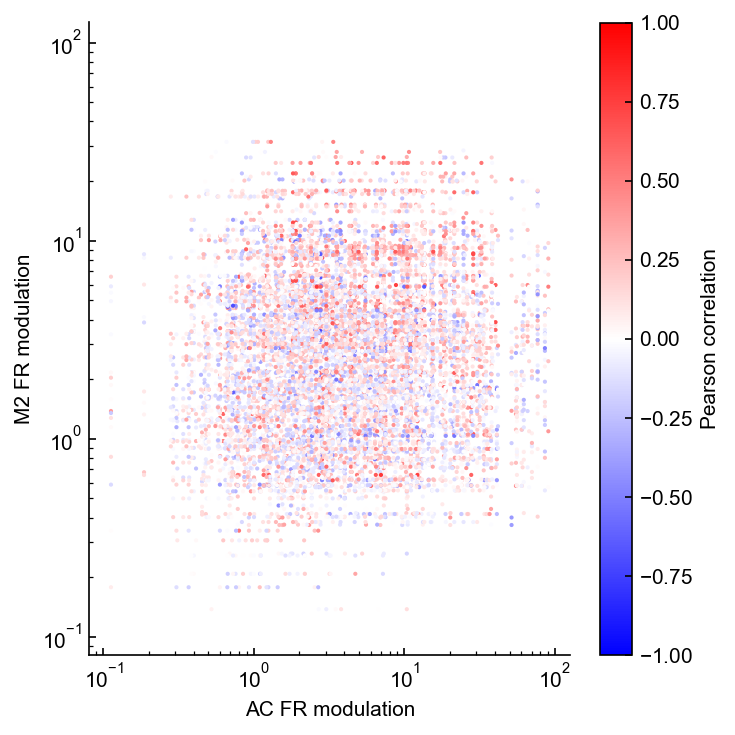

In [77]:
fig, ax = plt.subplots(figsize=(5,5))

colorvalue = (np.array(pearson_correlations)+1)/2
cmap = 'bwr'
#colorvalue = np.abs(pearson_correlations)
#cmap = 'inferno'
ax.scatter(AC_responsiveness,M2_responsiveness,c=colorvalue,cmap=cmap,s=1)
ax.set_xscale('log')
ax.set_yscale('log')

xlims = ax.get_xlim()
ylims = ax.get_ylim()
full_lims = [min(xlims[0],ylims[0]),max(xlims[1],ylims[1])]
ax.set_xlim(full_lims)
ax.set_ylim(full_lims)
ax.set_xlabel('AC FR modulation')
ax.set_ylabel('M2 FR modulation')

plt.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=-1,vmax=1),'bwr'),label='Pearson correlation')
plt.tight_layout()
plt.savefig(os.path.join('D:\\\\TempFigures','Correlation between regions.png'),transparent=False,facecolor="white")
pass

p-values for Mann-Whitney U test (Bonferroni adjsusted critical p-value = 0.0125):
late pre-reversal NCR-NCR vs CR-CR pval = 5.050122069646437e-66
early post-reversal NCR-NCR vs CR-CR pval = 4.723594930650584e-104
intermediate post-reversal NCR-NCR vs CR-CR pval = 0.00023073533854411319
late post-reversal NCR-NCR vs CR-CR pval = 0.008916745768310343


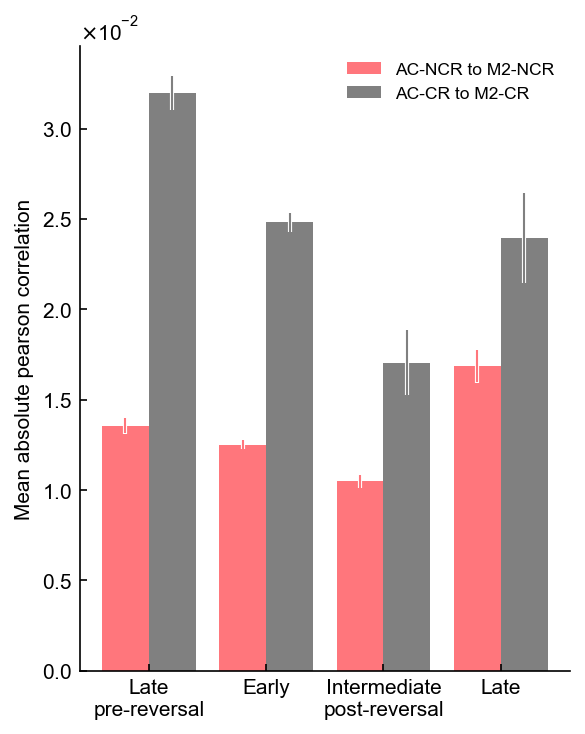

In [36]:
fig, ax = plt.subplots(figsize=(4,5))

conditions = ['late pre-reversal','early post-reversal','intermediate post-reversal','late post-reversal']
labels = ['Late\npre-reversal','Early','Intermediate\npost-reversal','Late']

pstatistics = []
for cond in conditions:
    data1 = np.abs(results['NCR'][cond])
    data2 = np.abs(results['CR'][cond])
    data1 = data1[np.isfinite(data1)]
    data2 = data2[np.isfinite(data2)]
    pstatistics.append(mannwhitneyu(data1,data2).pvalue)
print('p-values for Mann-Whitney U test (Bonferroni adjsusted critical p-value = '+str(0.05/len(conditions))+'):')
[print(cond + ' NCR-NCR vs CR-CR pval = '+str(pstat)) for cond,pstat in zip(conditions,pstatistics)]

NCRdata = np.array([np.nanmean(np.abs(results['NCR'][cond])) for cond in conditions])
NCRstd = np.array([np.nanstd(np.abs(results['NCR'][cond])) for cond in conditions])
NCRsem = np.array([sem(np.abs(results['NCR'][cond]),nan_policy='omit') for cond in conditions])
CRdata = np.array([np.nanmean(np.abs(results['CR'][cond])) for cond in conditions])
CRstd = np.array([np.nanstd(np.abs(results['CR'][cond])) for cond in conditions])
CRsem = np.array([sem(np.abs(results['CR'][cond]),nan_policy='omit') for cond in conditions])

MatchedData = SimpleNamespace()
MatchedData.NCRdata = NCRdata
MatchedData.NCRstd = NCRstd
MatchedData.NCRsem = NCRsem
MatchedData.CRdata = CRdata
MatchedData.CRstd = CRstd
MatchedData.CRsem = CRsem
MatchedData.conditions = conditions
MatchedData.labels = labels
#MatchedData.pvals = pstatistics

scale = 0.4
translation = scale/2
ax.bar(np.array([0,1,2,3])-translation,NCRdata,color=NCR_COLOR,width=scale,label='AC-NCR to M2-NCR')
ax.bar(np.array([0,1,2,3])+translation,CRdata,color=CR_COLOR,width=scale,label='AC-CR to M2-CR')

thick = 1
thicksc=2
ax.errorbar(np.array([0,1,2,3])-translation,NCRdata,NCRsem*1.01,lw=0,elinewidth=thick*thicksc,color='white',zorder=10)
ax.errorbar(np.array([0,1,2,3])-translation,NCRdata,NCRsem,lw=0,elinewidth=thick,color=NCR_COLOR,zorder=11)
ax.errorbar(np.array([0,1,2,3])+translation,CRdata,CRsem*1.01,lw=0,elinewidth=thick*thicksc,color='white',zorder=10)
ax.errorbar(np.array([0,1,2,3])+translation,CRdata,CRsem,lw=0,elinewidth=thick,color=CR_COLOR,zorder=11)

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(labels)
ax.set_ylabel('Mean absolute pearson correlation')
ax.legend(frameon=False,loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\TempFigures','Correlation across training paired FRmod.png'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\TempFigures','Correlation across training paired FRmod.pdf'),transparent=False,facecolor="white")

p-values for Mann-Whitney U test (Bonferroni adjsusted critical p-value = 0.0125):
late pre-reversal NCR-all vs CR-all pval = 3.3678853254480492e-25
early post-reversal NCR-all vs CR-all pval = 2.6667809656927847e-18
intermediate post-reversal NCR-all vs CR-all pval = 2.022439324856138e-05
late post-reversal NCR-all vs CR-all pval = 0.49397423653574835


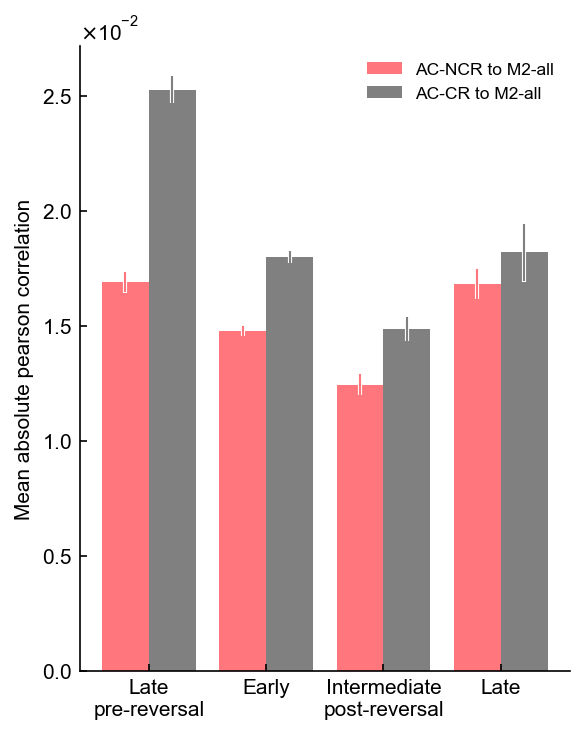

In [38]:
fig, ax = plt.subplots(figsize=(4,5))

conditions = ['late pre-reversal','early post-reversal','intermediate post-reversal','late post-reversal']
labels = ['Late\npre-reversal','Early','Intermediate\npost-reversal','Late']

pstatistics = []
for cond in conditions:
    data1 = np.abs(results['AC_NCR_to_all'][cond])
    data2 = np.abs(results['AC_CR_to_all'][cond])
    data1 = data1[np.isfinite(data1)]
    data2 = data2[np.isfinite(data2)]
    pstatistics.append(mannwhitneyu(data1,data2).pvalue)
print('p-values for Mann-Whitney U test (Bonferroni adjsusted critical p-value = '+str(0.05/len(conditions))+'):')
[print(cond + ' NCR-all vs CR-all pval = '+str(pstat)) for cond,pstat in zip(conditions,pstatistics)]

NCRdata = np.array([np.nanmean(np.abs(results['AC_NCR_to_all'][cond])) for cond in conditions])
NCRstd = np.array([np.nanstd(np.abs(results['AC_NCR_to_all'][cond])) for cond in conditions])
NCRsem = np.array([sem(np.abs(results['AC_NCR_to_all'][cond]),nan_policy='omit') for cond in conditions])
CRdata = np.array([np.nanmean(np.abs(results['AC_CR_to_all'][cond])) for cond in conditions])
CRstd = np.array([np.nanstd(np.abs(results['AC_CR_to_all'][cond])) for cond in conditions])
CRsem = np.array([sem(np.abs(results['AC_CR_to_all'][cond]),nan_policy='omit') for cond in conditions])

UnmatchedData = SimpleNamespace()
UnmatchedData.NCRdata = NCRdata
UnmatchedData.NCRstd = NCRstd
UnmatchedData.NCRsem = NCRsem
UnmatchedData.CRdata = CRdata
UnmatchedData.CRstd = CRstd
UnmatchedData.CRsem = CRsem
UnmatchedData.conditions = conditions
UnmatchedData.labels = labels
UnmatchedData.pvals = pstatistics

scale = 0.4
translation = scale/2
ax.bar(np.array([0,1,2,3])-translation,NCRdata,color=NCR_COLOR,width=scale,label='AC-NCR to M2-all')
ax.bar(np.array([0,1,2,3])+translation,CRdata,color=CR_COLOR,width=scale,label='AC-CR to M2-all')

thick = 1
thicksc=2
ax.errorbar(np.array([0,1,2,3])-translation,NCRdata,NCRsem*1.01,lw=0,elinewidth=thick*thicksc,color='white',zorder=10)
ax.errorbar(np.array([0,1,2,3])-translation,NCRdata,NCRsem,lw=0,elinewidth=thick,color=NCR_COLOR,zorder=11)
ax.errorbar(np.array([0,1,2,3])+translation,CRdata,CRsem*1.01,lw=0,elinewidth=thick*thicksc,color='white',zorder=10)
ax.errorbar(np.array([0,1,2,3])+translation,CRdata,CRsem,lw=0,elinewidth=thick,color=CR_COLOR,zorder=11)

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(labels)
ax.set_ylabel('Mean absolute pearson correlation')
ax.legend(frameon=False,loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\TempFigures','Correlation across training AC to all.png'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\TempFigures','Correlation across training AC to all.pdf'),transparent=False,facecolor="white")

In [41]:
TotalDataset = SimpleNamespace()
TotalDataset.rawData = results
TotalDataset.unmatchedData = UnmatchedData
TotalDataset.matchedData = MatchedData

filename = os.path.join('D:\\TempFigures','DataForCorrelationAnalysis.pickle')
with open(filename, 'wb') as f:
    pickle.dump(TotalDataset, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(filename,'rb') as f2:
    datatest = pickle.load(f2)
    
print(datatest)
pass

namespace(matchedData=namespace(CRdata=array([0.0319647 , 0.02482353, 0.01705309, 0.02396582]), CRsem=array([0.00093998, 0.00053337, 0.00179441, 0.0024887 ]), CRstd=array([0.03374777, 0.02522132, 0.01673716, 0.02438416]), NCRdata=array([0.01356584, 0.01250656, 0.01047306, 0.01686493]), NCRsem=array([0.00043335, 0.00023534, 0.00035715, 0.00090672]), NCRstd=array([0.01362819, 0.01316875, 0.00948969, 0.01817964]), conditions=['late pre-reversal', 'early post-reversal', 'intermediate post-reversal', 'late post-reversal'], labels=['Late\npre-reversal', 'Early', 'Intermediate\npost-reversal', 'Late']), rawData={'NCR': {'late pre-reversal': array([-1.19658348e-02,  1.42080271e-02,  1.41238613e-02,  1.03911425e-02,
       -1.58374572e-02, -3.05442002e-03, -6.55807426e-03, -1.11627750e-02,
       -7.05124968e-03,  8.63009955e-03,  5.18292641e-03,  9.21285797e-03,
        1.91342778e-02, -6.55336415e-03,  1.10544325e-02,  1.78999742e-02,
       -1.51372064e-02,  2.32772435e-02, -4.27267936e-03, 

In [166]:
print('Paired AC-M2 cell co-activation analysis. n = ...\n')
print('Late pre-reversal')
print('NCR-NCR: '+str(len(results['NCR']['late pre-reversal']))+' pairs')
print('NCR-all: '+str(len(results['AC_NCR_to_all']['late pre-reversal']))+' pairs')
print('CR-CR: '+str(len(results['CR']['late pre-reversal']))+' pairs')
print('CR-all: '+str(len(results['AC_CR_to_all']['late pre-reversal']))+' pairs')
print('\nEarly post-reversal')
print('NCR-NCR: '+str(len(results['NCR']['early post-reversal']))+' pairs')
print('NCR-all: '+str(len(results['AC_NCR_to_all']['early post-reversal']))+' pairs')
print('CR-CR: '+str(len(results['CR']['early post-reversal']))+' pairs')
print('CR-all: '+str(len(results['AC_CR_to_all']['early post-reversal']))+' pairs')
print('\nIntermediate post-reversal')
print('NCR-NCR: '+str(len(results['NCR']['intermediate post-reversal']))+' pairs')
print('NCR-all: '+str(len(results['AC_NCR_to_all']['intermediate post-reversal']))+' pairs')
print('CR-CR: '+str(len(results['CR']['intermediate post-reversal']))+' pairs')
print('CR-all: '+str(len(results['AC_CR_to_all']['intermediate post-reversal']))+' pairs')
print('\nLate post-reversal')
print('NCR-NCR: '+str(len(results['NCR']['late post-reversal']))+' pairs')
print('NCR-all: '+str(len(results['AC_NCR_to_all']['late post-reversal']))+' pairs')
print('CR-CR: '+str(len(results['CR']['late post-reversal']))+' pairs')
print('CR-all: '+str(len(results['AC_CR_to_all']['late post-reversal']))+' pairs')

Paired AC-M2 cell co-activation analysis. n = ...

Late pre-reversal
NCR-NCR: 999 pairs
NCR-all: 1971 pairs
CR-CR: 1301 pairs
CR-all: 2388 pairs

Early post-reversal
NCR-NCR: 3165 pairs
NCR-all: 4987 pairs
CR-CR: 2262 pairs
CR-all: 6019 pairs

Intermediate post-reversal
NCR-NCR: 710 pairs
NCR-all: 924 pairs
CR-CR: 88 pairs
CR-all: 787 pairs

Late post-reversal
NCR-NCR: 405 pairs
NCR-all: 725 pairs
CR-CR: 98 pairs
CR-all: 235 pairs


100%|██████████| 344/344 [00:00<00:00, 348.11it/s]


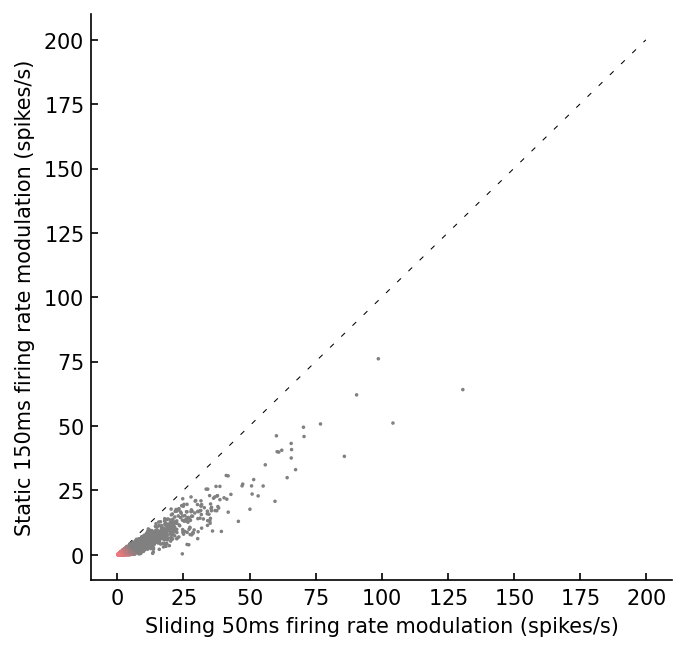

In [9]:
sess = []
clusts = []
R1 = []
R2 = []

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(directory,session)
    
    if sessionfile.meta.animal in ['BS_33','BS_67','BS_73','BS_78']:
        continue
    
    for clust in sessionfile.clusters.good:
        sess.append(session)
        clusts.append(clust)
        R1.append( (sessionfile.responsiveness[clust]['all_trials'].FRmodulation) )
        R2.append( (sessionfile.responsiveness[clust]['all_trials'].FRmodulation150) )
sess = np.array(sess)
clusts = np.array(clusts)
R1 = np.array(R1)
R2 = np.array(R2)
        
total = (np.array(R1)+np.array(R2))/2
        
trans = 1
fig, ax = plt.subplots(figsize=(5,5))
color=NCR_CR_cmap(np.array(total)/4)
ax.scatter(R1,R2,s=0.5,c=color,fc=color)
#ax.set_xlim([-10,80])
#ax.set_ylim([-10,80])

ax.plot([0,200],[0,200],color='k',lw=0.5,linestyle=(0, (5, 10)),zorder=-10)
#ax.plot([0,0],[-10,80],color='k',lw=0.5,zorder=-10)
#ax.plot([-10,80],[0,0],color='k',lw=0.5,zorder=-10)

#ax.set_xscale('log',base=10)
#ax.set_yscale('log',base=10)

ax.set_xlabel('Sliding 50ms firing rate modulation (spikes/s)')
ax.set_ylabel('Static 150ms firing rate modulation (spikes/s)')

plt.savefig(os.path.join('D:\\\\TempFigures','ResponsivenessSummaries','Sliding vs static modulation.pdf'),transparent=False,facecolor="white")

In [34]:
results['CR']

{'late pre-reversal': array([0.03827239, 0.00160387, 0.01122162, ..., 0.03556682, 0.06738638,
        0.05029233]),
 'early post-reversal': array([-0.01433726, -0.00648019, -0.00869997, ...,  0.09679197,
         0.02107509,  0.0573845 ]),
 'intermediate post-reversal': array([ 2.06593621e-02, -6.24741063e-03,  1.53868863e-02,  1.00063332e-02,
        -2.77442262e-04, -2.01993743e-02, -1.19757107e-02, -1.11161694e-02,
         4.96429811e-02,  1.05607704e-02,  2.22437456e-02,  6.74679952e-02,
        -1.49927205e-02, -1.00333989e-02, -2.31336125e-02, -1.15960221e-02,
        -6.63373031e-03, -4.63123499e-03,  4.75532994e-03, -3.52907297e-03,
         9.49805373e-02, -6.31675260e-03,  1.03104293e-02, -1.97574605e-02,
        -4.11065704e-02, -1.19813931e-02,  3.86524610e-02, -2.69191750e-02,
         2.57514497e-02,  8.46609667e-03,  2.15060015e-02,  7.31431541e-03,
        -8.18430877e-03, -1.68354674e-02,  3.94059934e-03,  1.67638090e-03,
        -2.95446870e-02,  4.09415455e-04,  6.5

In [28]:
mannwhitneyu(list(range(10)),list(range(10)),nan_policy='omit')

TypeError: mannwhitneyu() got an unexpected keyword argument 'nan_policy'

In [6]:
sessionfile.meta

namespace(directory='D:\\DualRecording\\DS_19\\DS_19 30\\AC\\',
          region='AC',
          animal='DS_19',
          probe=6928,
          date='5/19/2021',
          depth=1300,
          task='reversal',
          day_of_training=30,
          day_of_recording=20,
          day_of_reversal=19,
          length_in_samples=41103970.0,
          files=['May 19 2021 Dual DS_19_20001'],
          behavior='expert',
          condition='postreversal expert',
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=1370.1323333333332,
          length_in_minutes=22.835538888888887,
          length_in_trials=300)

In [14]:
numcells = 0
for session in sessions:
    sessionfile = ilep.loadSessionCached(directory,session)
    if sessionfile.meta.region == 'AC' and sessionfile.meta.condition == 'postreversal expert':
        numcells += len(sessionfile.clusters.good)

In [15]:
print(numcells)

431


In [144]:

def calculateResponsivenessInternal(sessionfile,populationAvgLickResponseInSamples,swindow=150,rwindow=100,verbose=False):
    responsiveness = dict()
    for clust in sessionfile.clusters.good:
        unitresponsiveness = calculateResponsivenessClusterInternal(sessionfile,populationAvgLickResponseInSamples,clust,swindow=swindow,rwindow=rwindow,verbose=verbose)
        if unitresponsiveness != None:
            responsiveness[clust] = unitresponsiveness
        else:
            print('responsiveness dict returned None')
    return responsiveness

def calculateResponsivenessClusterInternal(sessionfile,populationAvgLickResponseInSamples,clust,swindow=150,rwindow=100,verbose=False):#Window in ms
    responsiveness = dict()

    if not hasattr(sessionfile,'trim'):
        if verbose:
            print(sessionfile.meta.animal+' '+str(sessionfile.meta.date).replace('/','-')+' '+sessionfile.meta.region+' not trimmed')
        return None

    #Determine the no-go window to use
    avgLickResponseInSamples = populationAvgLickResponseInSamples
    if not np.all(np.isnan(sessionfile.trials.response)):
        avgLickResponseInSamples = np.nanmean(sessionfile.trials.response-sessionfile.trials.starts)
    
    #Set up conditions
    #Starting with just all trials because it seems like a good place to start
    ##########################################################################################################################

    all_conditions = ilep.getAllConditions(sessionfile,clust)
    for cond in all_conditions:
        responsiveness[cond] = all_conditions[cond]

    ##Condition A -- All Trials
    #condition = SimpleNamespace()
    #all_trials = np.full((sessionfile.meta.length_in_trials), True)
    #all_trials = np.array(np.where(all_trials)[0])
    #all_trials = all_trials[np.isin(all_trials,sessionfile.trim[clust].trimmed_trials)]
    #condition.trials = all_trials
    #condition.label = 'all_trials'
    #condition.color = 'grey'
    #responsiveness[condition.label] = condition
    #
    #if sessionfile.meta.task in ['opto nonreversal','opto reversal','opto switch']:
    #    condition = SimpleNamespace()
    #    laser_on = sessionfile.trials.laser_stimulation
    #    laser_on = np.array(np.where(laser_on)[0])
    #    laser_on = laser_on[np.isin(laser_on,sessionfile.trim[clust].trimmed_trials)]
    #    condition.trials = laser_on
    #    condition.label = 'laser_on'
    #    condition.color = 'blue'
    #    responsiveness[condition.label] = condition
    #
    #    condition = SimpleNamespace()
    #    laser_off = np.logical_not(sessionfile.trials.laser_stimulation)
    #    laser_off = np.array(np.where(laser_off)[0])
    #    laser_off = laser_off[np.isin(laser_off,sessionfile.trim[clust].trimmed_trials)]
    #    condition.trials = laser_off
    #    condition.label = 'laser_off'
    #    condition.color = 'grey'
    #    responsiveness[condition.label] = condition
    #
    #if sessionfile.meta.task in ['switch','opto switch']:
    #    condition = SimpleNamespace()
    #    preswitch = np.array(range(sessionfile.meta.first_reversal_trial))
    #    preswitch = preswitch[np.isin(preswitch,sessionfile.trim[clust].trimmed_trials)]
    #    condition.trials = preswitch
    #    condition.label = 'pre-switch'
    #    condition.color = 'grey'
    #    responsiveness[condition.label] = condition
    #
    #    condition = SimpleNamespace()
    #    postswitch = np.array(range(sessionfile.meta.first_reversal_trial,sessionfile.meta.length_in_trials))
    #    postswitch = postswitch[np.isin(postswitch,sessionfile.trim[clust].trimmed_trials)]
    #    condition.trials = postswitch
    #    condition.label = 'post-switch'
    #    condition.color = 'blue'
    #    responsiveness[condition.label] = condition

    if verbose:
        for cond in responsiveness:
            print(cond)

    ##########################################################################################################################
    
    #Caching search -- Unit
    idx = np.equal(sessionfile.spikes.clusters,clust)
    totaltimes = sessionfile.spikes.times[idx]
    
    for cond in responsiveness:
        
        swindow = 150
        rwindow = 50#ms
        slideincrement = 10#ms              #Sliding window implemented ~July 8th
        slideend = 200#ms
        numincrements = int((slideend - rwindow)/slideincrement + 1)#Plus one because range(x) is zero indexed

        numtrials = len(responsiveness[cond].trials)
        baselineFR = np.array([np.nan] * numtrials)
        t150FR = np.array([np.nan] * numtrials)
        modulationFR = np.zeros((numtrials,numincrements))
        modulationFR.fill(np.nan)
        
        for trialidx,trial in enumerate(responsiveness[cond].trials):
            trialstart = sessionfile.trials.starts[trial]

            #Caching search -- Trial
            trialcachestart = trialstart - 1*sessionfile.meta.fs
            trialcacheend = trialstart + 2.5*sessionfile.meta.fs
            cachespikeidxs = np.logical_and(      np.greater(totaltimes,trialcachestart) , np.less(totaltimes,trialcacheend)     )
            trialtimes = totaltimes#totaltimes[cachespikeidxs]

            #Caching search -- This trial -- Baseline bin 1 -- -150ms to 0ms
            starttime = trialstart - sessionfile.meta.fs * (swindow/1000)
            endtime = trialstart - sessionfile.meta.fs * 0
            baselinespikeidxs = np.logical_and(      np.greater(trialtimes,starttime) , np.less(trialtimes,endtime)     )
            baselineFR[trialidx] = np.sum(baselinespikeidxs) / (swindow/1000)

            #Caching search -- This trial -- 150ms tone bin -- 0ms to 150ms
            starttime = trialstart - sessionfile.meta.fs * 0
            endtime = trialstart + sessionfile.meta.fs * (swindow/1000)
            t150spikeidxs = np.logical_and(      np.greater(trialtimes,starttime) , np.less(trialtimes,endtime)     )
            t150FR[trialidx] = np.sum(t150spikeidxs) / (swindow/1000)
            
            for increment in range(numincrements):
                windowstart = trialstart + sessionfile.meta.fs * (increment*slideincrement)/1000
                windowend = windowstart + sessionfile.meta.fs * (rwindow)/1000
                modulationspikeidxs = np.logical_and(      np.greater(trialtimes,windowstart) , np.less(trialtimes,windowend)     )
                modulationFR[trialidx,increment] = np.sum(modulationspikeidxs) / (rwindow/1000)

        #FRmodulation150 is an old calculation of stimulus-responsiveness.
        #We do not use it anymore as mice respond too fast for us to distinguish
        #between stimulus and choice related modulations
        responsiveness[cond].FRmodulation150 = np.abs(np.mean(t150FR - baselineFR))

        #Fill out baselineFR so as to make it the same shape as FRmodulation so
        #We can subtract it. It's mean does not change.
        baselineFR = np.transpose(np.tile(baselineFR,(numincrements,1)))

        #Calculate different stages of firing rate modulation that allow
        #us to determine firing rate modulation as well as firing rate at
        #max modulation and baseline
        FR = np.mean(modulationFR,axis=0)
        modulation = np.mean(modulationFR-baselineFR,axis=0)
        absmodulation = np.abs(modulation)

        #Calculate the index of maximum modulation. This is the point at which
        #we calculate the firing rate modulation
        maxmodidx = np.argmax(absmodulation)

        #Save results to the dict to return up the execution stack
        responsiveness[cond].FRbaseline = np.mean(baselineFR)
        responsiveness[cond].FR = FR[maxmodidx]
        responsiveness[cond].FRmodulation = absmodulation[maxmodidx]
            
    return responsiveness

In [152]:
a = calculateResponsivenessClusterInternal(sessionfile,np.nan,clust,verbose=True)

all_trials
target_tone
nontarget_tone
go_response
nogo_response


In [151]:
clust = 15

In [147]:
sessionfile.clusters.good

array([ 1,  5,  7, 11, 15, 17, 24, 28, 47, 50, 51, 66, 68, 70, 77, 79, 81],
      dtype=int64)

In [150]:
[k for k in sessionfile.trim]

[1, 5, 6, 7, 11, 15, 17, 24, 28, 36, 47, 50, 51, 66, 68, 70, 77, 79, 81]

In [153]:
a

{'all_trials': namespace(trials=array([115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
                         128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
                         141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
                         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                         167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                         180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
                         193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
                         206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
                         219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
                         232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
                         245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 2